# Objective

Implement a neural network.


### Function implementations


* sigmoid
* softmax
* cross entropy log loss (binary and categorical)

### Optimizer implementations
* SGD
* Adam (TBD)

### Layer implementations


* Standardization
* Matmul
* Activation (sigmoid, softmax)
* Log loss output
* Batch normalization 

Mathjax formulas get corrupted in github.

### Classifier Implementations

* Binary classifiation with (matmul-loss) layers.
* Categorical classifiation with (matmul-ReLu-matmul-Relu-loss) layers.

# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

---

# Neural network overview

Structure of the network and how forward and backward propagations work.

<img src="image/nn_diagram.png" align="left">

# Concepts 

## Objective function

The network trains the layers so as to minimize the objective function ```L``` which calculates the loss. Each layer at ```i``` is a function $f_i$ which takes an input $X_i$ from a previous layer and outputs $Y_i = f(X_i)$. The post layers of the form an objective function $L_i$ for the layer: $L = L_i(Y_i)$. 


<img src="image/nn_functions.png" align="left">

## Forward path

The process where each layer ```i``` calculate its output $Y_i = f(X_i)$ and forward it to the next layer(s) as their input $X_{i+1}$.

## Backward path

The process of automatic differentication, or *back-propagation* where each layer calculates its gradient $\frac {\partial L_i(Y_i)}{\partial Y_i}$ , that is, the impact $Y_i$ will make on the objective ```L``` when it changes. With the gradient, we can apply the gradient descent $X_i = X_i - \lambda  \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i }{\partial X_i}$ to update $X_i$ that would reduce the objective ```L```.

## Cycle

A round-trip of a forward path and a backward path with a batch data set $(X, T)$. How many cycles to happen with each batch is an implementation decision. 

## Epoch

Total cycles to consume the entire training data.

---

# Terminologies

## X
A batch input to a layer. Matrix shape is ```(N, D)```.

* ```N``` : Number of rows in a batch X, or batch size
* ```D``` : Number of features in a data in X.


## T
Labels for X. There are two formats available for the label.

#### One Hot Encoding (OHE) labels

When a neural network predicts a class out of ```3``` classes for an input ```x``` and the correct class is ```2```, then the label ```t``` is specified as ```t = [0, 1, 0]```.

$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

#### Index labels

The label ```t``` is specified as ```t = 2```. 

$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \end{align*}
$

## W
A set of weight parameters of a node in a Matmul layer. Shape is ```(M, D)```.

* ```M``` : Number of nodes in a layer



# Matrix order

Use the row-order matrix. For instance, the weight matrix ```W``` of a Matmul layer has a shape ```(M, D)``` where each row in ```W``` represents a node in the layer. It will be efficient to use the column order matrix of shape ```(D, M)``` for ```W``` so that the matrix multiplication at a Matmul layer can be executed as ```X@W```  which is a ```shape:(N,D) @ shape:(D,M)``` operation without transpose. 

However, for the purpose of consistency and clarity, use the shape ```W:(M, D)``` although it will cause transposes ```W.T``` at the Matmul operations, and revese transposing ```dL/dW.T``` to ```dL/dW``` when updating ```W``` at the gradient descents.


---

# Python & Jupyter setups

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import copy
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

---

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [8]:
from common.weights import (
    xavier,
    he,
    uniform
)
from layer.matmul import Matmul

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

### Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Batch Normalization Layer

* [Understanding the backward pass through Batch Normalization Layer](http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
<img src="image/bn_back_propagation.png" align="left" />
<img src="image/batch_normalization_steps_small.jpg" align="left" />

---

# Activation layer

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

#### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

#### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [9]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

ImportError: cannot import name 'softmax' from 'common' (/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/common/__init__.py)

## Foward path
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Backward path

### Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

The formula is calculated by chaing the gradient from ***cross-entropy-log-loss***, and the gradients of the steps in ***softmax***.

#### Gradient from the cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


####  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

#### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



#### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



#### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [ ]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [10]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [11]:
N = 3
dJ = np.ones(N) / N
dJ

array([0.33333333, 0.33333333, 0.33333333])

---


# Gradient check

## Numerical gradient

The objective of back-propagation is to analytically calculate the gradient of the objective function $g(X_i) = \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i}{\partial X_i}$ at each layer. Suppose the shape of $X_i$ is ```(N, M)```. We can take an element of X at an index ```(n,m)``` and add a small change ```h```, then see what impact ```h``` makes by calculating the numerical gradient ```gn``` as: $
\begin {align*}
gn(X_i) = \frac {L_i(f_i(X_i+h)) - L_i(f_i(X_i-h))} {2h }
\end {align*}
$. Then $gn(X_i) \approx \; $gn(X_i)$ would assure the gradient calculation should be correct.

In [15]:
from common.constants import (
    OFFSET_DELTA
)
from common.functions import (
    numerical_jacobian,
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, TYPE_FLOAT],
        delta: Optional[TYPE_FLOAT] = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix 


### Consideration

#### Instability of numerical calculations

A float number can have infinite length e.g. ```1/3``` in the real world, but a computer needs to approximate it by rounding it to fit into a limited storage. Need to assure numerical errors are prevented or detected while calculating gradient numerically. See [Numerical errors](numerical_errors.ipynb). 

### Example 

Comparing the analytical gradient and the numerical gradient of a logistic log loss ```L = -(1-T) * log(Z)``` where ```T = 0``` and ```Z=sigmoid(X)```.

In [16]:
def t_0_logistic_log_loss(X):
    """Logistic log loss function"""
    # --------------------------------------------------------------------------------
    # For numerical stability, re-forumulate the logistic log loss -(1-T)log(1-Z) as
    # X + log(1+exp(-X)).
    
    # By Reza.B
    # Let z=1/(1+p), p= e^(-x), then log(1-z)=log(p)-log(1+p), which is more stable
    # in terms of rounding errors (we got rid of division, which is the main issue 
    # in numerical instabilities). 
    # --------------------------------------------------------------------------------
    L = np.sum(X + np.log(1 + np.exp(-X)))
    return L.tolist()

def gradient_t_0_loss(X):
    return 1 / (1 + np.exp(-X))

X = np.random.uniform(-5, 5, (2,2))
print(f"The analytical and numerical gradients of the logistic log loss for X:\n{X}\n")

analytical_gradient = gradient_t_0_loss(X)
numerical_gradient = numerical_jacobian(t_0_logistic_log_loss, X)

print(f"Analytical gradient:\n{analytical_gradient}\n")
print(f"Numerical gradient:\n{numerical_gradient}")

The analytical and numerical gradients of the logistic log loss for X:
[[ 1.39876797  1.47547941]
 [-2.82766083  0.2708768 ]]

Analytical gradient:
[[0.80198831 0.8138888 ]
 [0.05584761 0.56730814]]

Numerical gradient:
[[0.80198959 0.81389118]
 [0.05584422 0.5673062 ]]


---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [20]:
%reload_ext autoreload
%autoreload 2
from common.functions import (
    transform_X_T,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
import common.weights as weights 

from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [21]:
N = 500    # Number of plots
D = 2      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
_X = np.c_[
    np.ones(N),     # Bias
    X
]
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


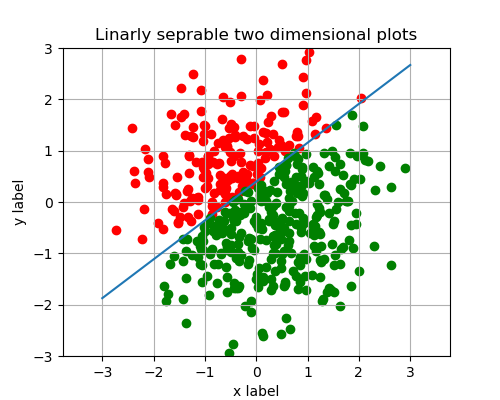

In [22]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 0], X[T==0, 1], c='red')
ax.scatter(X[T==1, 0], X[T==1, 1], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

In [23]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


## Sigmoid classifier training


<IPython.core.display.Javascript object>


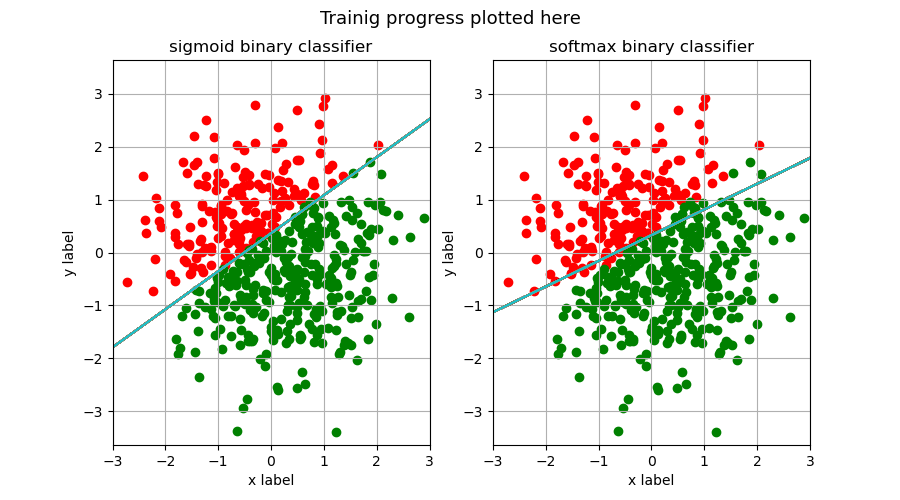

Train a sigmoid classifier to find optimal W (0.30221778378859726, 0.5753876489423223, -0.7599957003868743) for the boundary.
iteration 0 Loss 0.8767776593105274


array([[ 0.65701553,  1.29905933, -1.80488697]])

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
for i in range(2):
    ax[i].scatter(X[T==0, 0], X[T==0, 1], c='red')
    ax[i].scatter(X[T==1, 0], X[T==1, 1], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")




print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 50

M = 1
W = weights.xavier(M, D+1)    # Xavier initialization for Sigmoid
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False,
    callback=draw
)

In [25]:
%lprun \
    -T train_sigmoid_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=sigmoid_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_sigmoid_classifier.log', 'r').read())

sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded the boundary 10.361632918473205, hence clipping.
sigmoid: X value exceeded

iteration 0 Loss 0.2217327675650921

*** Profile printout saved to text file 'train_sigmoid_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 1.12744 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                                                   log_loss_function: Callable,
    56                                                   

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [26]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 2                      
W = weights.he(M, D+1)
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False, 
    callback=draw
)

Train a softmax classifier to find optimal W (0.30221778378859726, 0.5753876489423223, -0.7599957003868743) for the boundary.
iteration 0 Loss 0.7465941070702904
iteration 50 Loss 0.1673590950957016


array([[-0.53789901, -0.79733895,  1.6396573 ],
       [ 0.75027934,  1.58786065, -1.6892386 ]])

In [27]:
%lprun \
    -T train_softmax_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=softmax_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_softmax_classifier.log', 'r').read())

iteration 0 Loss 0.12952066576968743
iteration 50 Loss 0.11185940137470926

*** Profile printout saved to text file 'train_softmax_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 2.33835 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                                                   log_loss_function: Callable,
    56            

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [30]:
%reload_ext autoreload
%autoreload 2
from common.functions import (
    prediction_grid,
)
from data import (
    linear_separable_sectors,
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [31]:
print(f"Train a categorical classifier")
N = 1000
D = 2      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)
X_backup = copy.deepcopy(X)
T_backup = copy.deepcopy(T)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


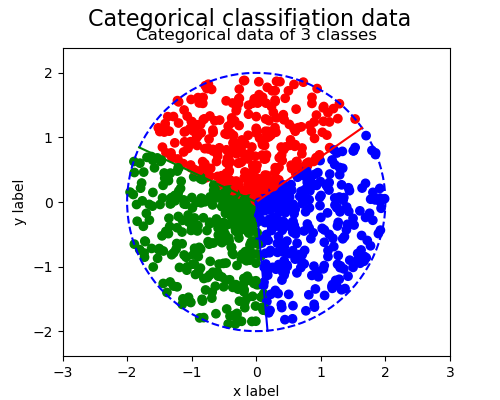

In [32]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y = COLOR_LABELS[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,0], X[::,1], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


### Train on linearly separable multiple categories

In [34]:
MAX_TEST_TIMES = 500
W = weights.he(M, D+1)
W_backup = copy.deepcopy(W)
optimizer = SGD(lr=0.5)

# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

Expected dL/dW 
[[ 0.00310715  0.07756197 -0.15817592]
 [ 0.00584307  0.15532855  0.12183819]
 [-0.09743754 -0.11954054  0.03627186]]
Diff
[[ 0.00109669 -0.00719776  0.01280315]
 [-0.00270831 -0.00776283 -0.01002311]
 [ 0.0074258   0.00866538 -0.00420648]]
Expected dL/dW 
[[-0.00213502  0.06767291 -0.143428  ]
 [-0.00860488  0.1330403   0.10664041]
 [-0.12102947 -0.13761925  0.02302639]]
Diff
[[-0.00109171 -0.00816177  0.00972542]
 [-0.00116568 -0.00620329 -0.00657098]
 [ 0.00900396  0.01000855 -0.00382173]]


iteration 0 Loss 1.1707404065002
iteration 10 Loss 0.6953012949328763
iteration 20 Loss 0.5505131183071472
iteration 30 Loss 0.4769417512341984
iteration 40 Loss 0.43110055311083373
iteration 50 Loss 0.399156434287831
iteration 60 Loss 0.37523978220269405
iteration 70 Loss 0.3564332019234276
iteration 80 Loss 0.34112862990897735
iteration 90 Loss 0.3283424170266019
iteration 100 Loss 0.31743177818819707
iteration 110 Loss 0.3079648884163496
iteration 120 Loss 0.2996410014412307
iteration 130 Loss 0.29223697930121406
iteration 140 Loss 0.28559114002846125
iteration 150 Loss 0.27957623937351284
iteration 160 Loss 0.2740934331299693
iteration 170 Loss 0.2690670740334314
iteration 180 Loss 0.2644327663861898
iteration 190 Loss 0.2601399061536253
iteration 200 Loss 0.2561460762870561
iteration 210 Loss 0.2524170466687244
iteration 220 Loss 0.2489237955798434
iteration 230 Loss 0.24564185533001026
iteration 240 Loss 0.24254866608465597
iteration 250 Loss 0.23962556924759984
iteration 260 Los

### Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


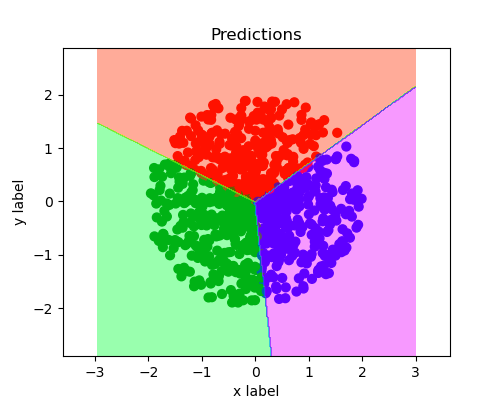

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:67: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [35]:
fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

plt.show()

## Non-linearly separable data

In [38]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from common.functions import (
    prediction_grid_2d
)
from network import (
    train_two_layer_classifier
)
from drawing import (
    plot,
    scatter
)

### Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


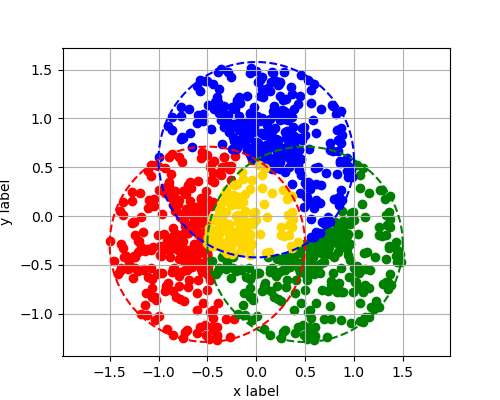

In [39]:
__M = 3        # Number of circles
__N = 500
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.0, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')
plt.draw()
plt.show()
import time
time.sleep(1)
time.sleep(1)


In [40]:
# Stack all circles and intersect
X = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))
X = X[indices]
T = T[indices]
Y = COLOR_LABELS[T]
X, T = transform_X_T(X, T)
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

print(f"X:{X.shape} T:{T.shape} ")

X:(994, 2) T:(994,) 


### Train on non-linear separable data

During the training, the loss often does not decrease. 

> Iteration [19976]: Loss[0.06914290965513335] has not improved from the previous [0.06914225566912098] for 1 times.

<ins>If reduce the **learning rate** at those points, the situation gets worse </ins>(continuous non-improvements instead of sporadic) and the training fails (the result model cannot classify). If keep using the same learning rate, the non-improvement continues more frequently but the training itself makes a progress. 

Need to understand why it happens and why reducing the rate will make the training fail. Possibl approach is visualizing the loss function with contour lines and the track of the gradient descent to see the terrain it went through. 

In [62]:
MAX_TEST_TIMES = 15000
D = 2
M1 = 8
W1 = weights.he(M1, D+1)
M2: int = M                 # Number of categories to classify
W2 = weights.he(M2, M1+1)
optimizer = SGD(lr=0.5)

### Trick
Because the data is almost zero-centered, the bias ```x0``` is not required. Hence set the bias weight ```w0``` to zero to short-cut the training. Without, the 

In [63]:
W1_bias_0 = copy.deepcopy(W1)  # np.copy() is sufficient without deepcopy.
W2_bias_0 = copy.deepcopy(W2)
W1_bias_0[
    ::,
    0
] = 0
W2_bias_0[
    ::,
    0
] = 0

In [64]:
W1_result_with_trick, W2_result_with_trick, objective, prediction_with_trick, history_with_trick = \
train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1_bias_0,
    M2=M2,
    W2=W2_bias_0,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.348927411649078
iteration 100 Loss 0.45228720190810023
iteration 200 Loss 0.41455265449751494
iteration 300 Loss 0.3979968787179447
iteration 400 Loss 0.38981117500609314
iteration 500 Loss 0.38384055409094303
iteration 600 Loss 0.37829803705055043
iteration 700 Loss 0.3740090582495029
iteration 800 Loss 0.37073472754837916
iteration 900 Loss 0.3677349061585113
iteration 1000 Loss 0.3652137643776135
iteration 1100 Loss 0.3628801665461863
iteration 1200 Loss 0.36071119865809015
iteration 1300 Loss 0.358558071821076
iteration 1400 Loss 0.3563726382085312
iteration 1500 Loss 0.3541998286021909
iteration 1600 Loss 0.35202150315555775
iteration 1700 Loss 0.34976062650281653
iteration 1800 Loss 0.3473958884920826
iteration 1900 Loss 0.3448924530443365
iteration 2000 Loss 0.3423429637295841
iteration 2100 Loss 0.33976060989965035
iteration 2200 Loss 0.33710627306112384
iteration 2300 Loss 0.33415954159603767
iteration 2400 Loss 0.3310410947511963
iteration 2500 Loss 0.32784

Iteration [4497]: Loss[0.27543824056442107] has not improved from the previous [0.27543225555287176] for 1 times.
Iteration [4501]: Loss[0.27538780411683716] has not improved from the previous [0.27538207157408556] for 1 times.
Iteration [4503]: Loss[0.2753616701928065] has not improved from the previous [0.2753526628848225] for 1 times.
Iteration [4507]: Loss[0.27530529905650564] has not improved from the previous [0.27529861470479083] for 1 times.


iteration 4500 Loss 0.27538207157408556


Iteration [4509]: Loss[0.2752801822067295] has not improved from the previous [0.27527235847086445] for 1 times.
Iteration [4511]: Loss[0.27525557649715426] has not improved from the previous [0.2752549017475045] for 1 times.
Iteration [4513]: Loss[0.2752270636870276] has not improved from the previous [0.2752215931110687] for 1 times.
Iteration [4515]: Loss[0.2752004253499618] has not improved from the previous [0.27519417766935356] for 1 times.
Iteration [4519]: Loss[0.2751457382298728] has not improved from the previous [0.27514223776031266] for 1 times.
Iteration [4521]: Loss[0.2751190424085199] has not improved from the previous [0.27511508456928346] for 1 times.
Iteration [4525]: Loss[0.2750649880306061] has not improved from the previous [0.2750637682964868] for 1 times.
Iteration [4527]: Loss[0.275038137503516] has not improved from the previous [0.2750364343963138] for 1 times.
Iteration [4578]: Loss[0.27436924711968164] has not improved from the previous [0.2743687012252418] 

iteration 4600 Loss 0.27411475619285364


Iteration [4624]: Loss[0.27381660692303944] has not improved from the previous [0.27381383846102425] for 1 times.
Iteration [4630]: Loss[0.2737422617473728] has not improved from the previous [0.2737355559448725] for 1 times.
Iteration [4636]: Loss[0.27366821589068824] has not improved from the previous [0.27365760218789] for 1 times.
Iteration [4640]: Loss[0.2736080666538387] has not improved from the previous [0.2736056924391261] for 1 times.
Iteration [4642]: Loss[0.2735946070415218] has not improved from the previous [0.27357984599205204] for 1 times.
Iteration [4644]: Loss[0.273560058243499] has not improved from the previous [0.2735569321706365] for 1 times.
Iteration [4646]: Loss[0.2735343506620123] has not improved from the previous [0.2735281700761799] for 1 times.
Iteration [4648]: Loss[0.2735209402514124] has not improved from the previous [0.27350214948586415] for 1 times.
Iteration [4650]: Loss[0.2734864375033264] has not improved from the previous [0.2734795093470906] for

iteration 4700 Loss 0.2728222306281753


Iteration [4720]: Loss[0.27257870281058943] has not improved from the previous [0.2725745065024504] for 1 times.
Iteration [4722]: Loss[0.2725519456698569] has not improved from the previous [0.27255097621956387] for 1 times.
Iteration [4732]: Loss[0.27242318227960566] has not improved from the previous [0.27242162103728146] for 1 times.


iteration 4800 Loss 0.2716176739649354
iteration 4900 Loss 0.2705058828385443
iteration 5000 Loss 0.26944311837036805
iteration 5100 Loss 0.26841925721393595


Iteration [5185]: Loss[0.26759495513786585] has not improved from the previous [0.26758810944889294] for 1 times.
Iteration [5187]: Loss[0.26757857096020654] has not improved from the previous [0.2675722343715157] for 1 times.
Iteration [5189]: Loss[0.2675645690054904] has not improved from the previous [0.26756150132885587] for 1 times.
Iteration [5191]: Loss[0.2675416285438974] has not improved from the previous [0.2675380105108743] for 1 times.
Iteration [5193]: Loss[0.2675275467316092] has not improved from the previous [0.26751887011481507] for 1 times.
Iteration [5195]: Loss[0.26750647718671083] has not improved from the previous [0.2675061050123117] for 1 times.
Iteration [5205]: Loss[0.26740219512466934] has not improved from the previous [0.2673967069198807] for 1 times.
Iteration [5207]: Loss[0.26738986579937835] has not improved from the previous [0.2673875507451173] for 1 times.
Iteration [5209]: Loss[0.26737218577117267] has not improved from the previous [0.26736538334005

iteration 5200 Loss 0.2674358235557267


Iteration [5215]: Loss[0.26731124104354237] has not improved from the previous [0.2673076938140993] for 1 times.
Iteration [5221]: Loss[0.267253157556887] has not improved from the previous [0.2672500071890798] for 1 times.
Iteration [5223]: Loss[0.2672355465115302] has not improved from the previous [0.2672307096136368] for 1 times.
Iteration [5225]: Loss[0.267219324633953] has not improved from the previous [0.26721742580611474] for 1 times.
Iteration [5227]: Loss[0.267199601643266] has not improved from the previous [0.2671949660045559] for 1 times.
Iteration [5229]: Loss[0.26718388554660905] has not improved from the previous [0.26717553152032275] for 1 times.
Iteration [5231]: Loss[0.2671648181631597] has not improved from the previous [0.2671633532235429] for 1 times.
Iteration [5233]: Loss[0.26714360735473724] has not improved from the previous [0.26713956549040735] for 1 times.
Iteration [5235]: Loss[0.26712559858042434] has not improved from the previous [0.26711713059776393] 

iteration 5300 Loss 0.26650267595370825


Iteration [5313]: Loss[0.26640112318082965] has not improved from the previous [0.26639476721587163] for 1 times.
Iteration [5315]: Loss[0.2663821462053747] has not improved from the previous [0.26638206589295854] for 1 times.
Iteration [5317]: Loss[0.2663605408550359] has not improved from the previous [0.26635888110746614] for 1 times.
Iteration [5319]: Loss[0.26634474694312493] has not improved from the previous [0.2663396209725266] for 1 times.
Iteration [5323]: Loss[0.26630361768757543] has not improved from the previous [0.2663001665312358] for 1 times.
Iteration [5325]: Loss[0.26628601450419] has not improved from the previous [0.26628292088229955] for 1 times.
Iteration [5329]: Loss[0.2662481159309601] has not improved from the previous [0.26624630794162385] for 1 times.
Iteration [5331]: Loss[0.2662333135659762] has not improved from the previous [0.2662280855827278] for 1 times.
Iteration [5337]: Loss[0.2661782751458156] has not improved from the previous [0.26617316422785026

iteration 5400 Loss 0.26559696345215844


Iteration [5438]: Loss[0.26527070343724457] has not improved from the previous [0.265270060714874] for 1 times.
Iteration [5450]: Loss[0.2651659928515756] has not improved from the previous [0.2651642758340156] for 1 times.
Iteration [5462]: Loss[0.2650580353423507] has not improved from the previous [0.26505657976942665] for 1 times.
Iteration [5472]: Loss[0.2649650181213609] has not improved from the previous [0.2649636993920175] for 1 times.
Iteration [5478]: Loss[0.2649202068842632] has not improved from the previous [0.26491412276979287] for 1 times.
Iteration [5484]: Loss[0.2648668257485082] has not improved from the previous [0.26486460213605734] for 1 times.
Iteration [5490]: Loss[0.2648077938764259] has not improved from the previous [0.26480564412167457] for 1 times.
Iteration [5496]: Loss[0.264763797094954] has not improved from the previous [0.264756079841242] for 1 times.
Iteration [5500]: Loss[0.264725537314973] has not improved from the previous [0.264723831426977] for 1

iteration 5500 Loss 0.264725537314973


Iteration [5512]: Loss[0.26461140922652276] has not improved from the previous [0.2646103091290166] for 1 times.
Iteration [5514]: Loss[0.26460616502953294] has not improved from the previous [0.26459805445853213] for 1 times.
Iteration [5516]: Loss[0.2646001862071337] has not improved from the previous [0.26459951225699346] for 1 times.
Iteration [5520]: Loss[0.26460178757032116] has not improved from the previous [0.2645979069287158] for 1 times.
Iteration [5524]: Loss[0.2645842307051444] has not improved from the previous [0.26457924814084677] for 1 times.
Iteration [5530]: Loss[0.2645481694219623] has not improved from the previous [0.2645426119365963] for 1 times.
Iteration [5536]: Loss[0.26450474165565563] has not improved from the previous [0.26449983486989104] for 1 times.
Iteration [5542]: Loss[0.26445533813243427] has not improved from the previous [0.264449115409226] for 1 times.
Iteration [5548]: Loss[0.26440714687733013] has not improved from the previous [0.26440169214654

iteration 5600 Loss 0.2640598373656052


Iteration [5616]: Loss[0.26396711133218875] has not improved from the previous [0.26396571371710553] for 1 times.
Iteration [5622]: Loss[0.26392085387690517] has not improved from the previous [0.26391867099224414] for 1 times.
Iteration [5628]: Loss[0.2638724058283812] has not improved from the previous [0.26386775604077517] for 1 times.
Iteration [5634]: Loss[0.2638302274018611] has not improved from the previous [0.2638259122945485] for 1 times.
Iteration [5640]: Loss[0.2637831912080841] has not improved from the previous [0.26377710803493926] for 1 times.
Iteration [5642]: Loss[0.263761374238076] has not improved from the previous [0.2637564636460628] for 1 times.
Iteration [5644]: Loss[0.2637427388600994] has not improved from the previous [0.26373709376151755] for 1 times.
Iteration [5646]: Loss[0.2637362922522795] has not improved from the previous [0.26372165977850454] for 1 times.
Iteration [5648]: Loss[0.2637188523936355] has not improved from the previous [0.2637156361619084

iteration 5700 Loss 0.263338233664543


Iteration [5716]: Loss[0.2632195381121249] has not improved from the previous [0.2631868537115846] for 1 times.
Iteration [5718]: Loss[0.26319787302013853] has not improved from the previous [0.26317015712306285] for 1 times.
Iteration [5720]: Loss[0.2631792115595173] has not improved from the previous [0.26315110025632454] for 1 times.
Iteration [5722]: Loss[0.2631731366048796] has not improved from the previous [0.26313510411130836] for 1 times.
Iteration [5724]: Loss[0.2631514050486957] has not improved from the previous [0.26312518522830675] for 1 times.
Iteration [5726]: Loss[0.26313798284936823] has not improved from the previous [0.26311297341520906] for 1 times.
Iteration [5728]: Loss[0.2631313234574564] has not improved from the previous [0.263095781861116] for 1 times.
Iteration [5730]: Loss[0.2631049103727134] has not improved from the previous [0.26307221675029274] for 1 times.
Iteration [5732]: Loss[0.26309925436099657] has not improved from the previous [0.263055084764827

iteration 5800 Loss 0.26238751183056935


Iteration [5826]: Loss[0.26240972657671174] has not improved from the previous [0.2623544786865717] for 1 times.
Iteration [5828]: Loss[0.2624103889036395] has not improved from the previous [0.2623451630912918] for 1 times.
Iteration [5830]: Loss[0.2623943990154103] has not improved from the previous [0.26234103611457427] for 1 times.
Iteration [5832]: Loss[0.26238696490514185] has not improved from the previous [0.2623143538931257] for 1 times.
Iteration [5834]: Loss[0.2624000713290908] has not improved from the previous [0.26234845412333685] for 1 times.
Iteration [5836]: Loss[0.26237782454138386] has not improved from the previous [0.26232437925702606] for 1 times.
Iteration [5838]: Loss[0.26232872303473226] has not improved from the previous [0.2623050028850586] for 1 times.
Iteration [5840]: Loss[0.2622765231746434] has not improved from the previous [0.2622505230262345] for 1 times.
Iteration [5844]: Loss[0.2621659728572228] has not improved from the previous [0.2621620498879980

iteration 5900 Loss 0.2619147448692402


Iteration [5910]: Loss[0.2620379967594821] has not improved from the previous [0.26198401765740265] for 1 times.
Iteration [5912]: Loss[0.2620786217502415] has not improved from the previous [0.26200781069005125] for 1 times.
Iteration [5913]: Loss[0.26209125843996744] has not improved from the previous [0.2620786217502415] for 2 times.
Iteration [5914]: Loss[0.2621304952618212] has not improved from the previous [0.26209125843996744] for 3 times.
Iteration [5916]: Loss[0.2621541241810314] has not improved from the previous [0.2620980290289977] for 1 times.
Iteration [5918]: Loss[0.2621842166085083] has not improved from the previous [0.2621434322452519] for 1 times.
Iteration [5919]: Loss[0.26218754353520995] has not improved from the previous [0.2621842166085083] for 2 times.
Iteration [5920]: Loss[0.26223726599154956] has not improved from the previous [0.26218754353520995] for 3 times.
Iteration [5922]: Loss[0.2622050418425983] has not improved from the previous [0.2621600296027473

iteration 6000 Loss 0.26073564990962605
iteration 6100 Loss 0.26006254280301627
iteration 6200 Loss 0.2594054859247334


Iteration [6286]: Loss[0.25887087115473506] has not improved from the previous [0.2588704763879952] for 1 times.


iteration 6300 Loss 0.2587812051630075


Iteration [6328]: Loss[0.2586088641799964] has not improved from the previous [0.25860876193258475] for 1 times.


iteration 6400 Loss 0.25816191973172686


Iteration [6473]: Loss[0.2577211978254453] has not improved from the previous [0.2577206793949818] for 1 times.
Iteration [6491]: Loss[0.2576099550000658] has not improved from the previous [0.25760981146425377] for 1 times.


iteration 6500 Loss 0.2575507903618569
iteration 6600 Loss 0.25695644424250397


Iteration [6687]: Loss[0.25646391208016633] has not improved from the previous [0.25646335314254] for 1 times.
Iteration [6688]: Loss[0.25647267030476434] has not improved from the previous [0.25646391208016633] for 2 times.
Iteration [6689]: Loss[0.2564868188443416] has not improved from the previous [0.25647267030476434] for 3 times.
Iteration [6690]: Loss[0.2564954585163411] has not improved from the previous [0.2564868188443416] for 4 times.
Iteration [6691]: Loss[0.25650460408401154] has not improved from the previous [0.2564954585163411] for 5 times.
Iteration [6692]: Loss[0.25650658926054676] has not improved from the previous [0.25650460408401154] for 6 times.
Iteration [6707]: Loss[0.2564032706536797] has not improved from the previous [0.256400438532684] for 1 times.


iteration 6700 Loss 0.2564355593452574


Iteration [6717]: Loss[0.2563494807558342] has not improved from the previous [0.2563482111423805] for 1 times.
Iteration [6723]: Loss[0.25631493831443564] has not improved from the previous [0.25631145930802207] for 1 times.
Iteration [6729]: Loss[0.25626908507578927] has not improved from the previous [0.25626720178207185] for 1 times.
Iteration [6737]: Loss[0.2561928221359195] has not improved from the previous [0.2561916116078281] for 1 times.
Iteration [6739]: Loss[0.2561936820833478] has not improved from the previous [0.2561904436309848] for 1 times.
Iteration [6741]: Loss[0.2561829275598024] has not improved from the previous [0.2561809760266889] for 1 times.
Iteration [6747]: Loss[0.2561489953631938] has not improved from the previous [0.25614633120750024] for 1 times.
Iteration [6749]: Loss[0.25614280499655634] has not improved from the previous [0.2561375674463993] for 1 times.
Iteration [6759]: Loss[0.25608678869605567] has not improved from the previous [0.2560855843592424

iteration 6800 Loss 0.2558649719463315


Iteration [6827]: Loss[0.25572287661175036] has not improved from the previous [0.25572123616386583] for 1 times.
Iteration [6828]: Loss[0.2557271899936585] has not improved from the previous [0.25572287661175036] for 2 times.
Iteration [6847]: Loss[0.255617236876899] has not improved from the previous [0.2556168691039894] for 1 times.
Iteration [6880]: Loss[0.25544569064154027] has not improved from the previous [0.25544529751260214] for 1 times.
Iteration [6884]: Loss[0.2554265486451234] has not improved from the previous [0.25542614000471475] for 1 times.
Iteration [6888]: Loss[0.2554050952700059] has not improved from the previous [0.2554034606117098] for 1 times.
Iteration [6896]: Loss[0.25536538692072447] has not improved from the previous [0.2553630719540408] for 1 times.
Iteration [6898]: Loss[0.2553608960842936] has not improved from the previous [0.2553555900159506] for 1 times.
Iteration [6902]: Loss[0.2553351841001934] has not improved from the previous [0.25533158062229444

iteration 6900 Loss 0.2553432912435191


Iteration [6908]: Loss[0.2553072687253992] has not improved from the previous [0.25530619022668904] for 1 times.
Iteration [6910]: Loss[0.2553024770670859] has not improved from the previous [0.2552974649243369] for 1 times.
Iteration [6912]: Loss[0.2552888124803909] has not improved from the previous [0.2552881408602129] for 1 times.
Iteration [6914]: Loss[0.25527712355825805] has not improved from the previous [0.25527531890278693] for 1 times.
Iteration [6916]: Loss[0.25526624468703646] has not improved from the previous [0.25526302602361606] for 1 times.
Iteration [6918]: Loss[0.25526111047560446] has not improved from the previous [0.2552555314075873] for 1 times.
Iteration [6920]: Loss[0.25525277851717393] has not improved from the previous [0.255246279540944] for 1 times.
Iteration [6922]: Loss[0.25523733821416805] has not improved from the previous [0.25523498783977777] for 1 times.
Iteration [6924]: Loss[0.2552313425786883] has not improved from the previous [0.255221841246724

iteration 7000 Loss 0.254818396398585


Iteration [7040]: Loss[0.2546216696725356] has not improved from the previous [0.2546213001087833] for 1 times.
Iteration [7050]: Loss[0.2545734876365418] has not improved from the previous [0.2545724336785061] for 1 times.
Iteration [7068]: Loss[0.2544827031799104] has not improved from the previous [0.2544817862361249] for 1 times.
Iteration [7072]: Loss[0.2544622042890326] has not improved from the previous [0.2544609980888644] for 1 times.
Iteration [7076]: Loss[0.25444192023442125] has not improved from the previous [0.2544406722003044] for 1 times.
Iteration [7080]: Loss[0.2544231121598266] has not improved from the previous [0.25442099256636663] for 1 times.
Iteration [7082]: Loss[0.2544131167457804] has not improved from the previous [0.2544108253193997] for 1 times.
Iteration [7086]: Loss[0.2543933635352639] has not improved from the previous [0.2543908965785303] for 1 times.
Iteration [7090]: Loss[0.25437385604024704] has not improved from the previous [0.25437156239014735] f

iteration 7100 Loss 0.25432632171592245


Iteration [7136]: Loss[0.25415077259175817] has not improved from the previous [0.25414907501626477] for 1 times.
Iteration [7140]: Loss[0.254132329754952] has not improved from the previous [0.2541306285034344] for 1 times.
Iteration [7144]: Loss[0.25411349179938764] has not improved from the previous [0.25411189286830455] for 1 times.


iteration 7200 Loss 0.2538379178215972
iteration 7300 Loss 0.25336903902254926
iteration 7400 Loss 0.2529102426605936
iteration 7500 Loss 0.25245988950794024
iteration 7600 Loss 0.25201636354302903
iteration 7700 Loss 0.2515815530177133
iteration 7800 Loss 0.2511549051481922


Iteration [7908]: Loss[0.2507100514500809] has not improved from the previous [0.2507070019552853] for 1 times.
Iteration [7909]: Loss[0.2507120321149702] has not improved from the previous [0.2507100514500809] for 2 times.
Iteration [7910]: Loss[0.250718887675256] has not improved from the previous [0.2507120321149702] for 3 times.
Iteration [7911]: Loss[0.25072250148944364] has not improved from the previous [0.250718887675256] for 4 times.
Iteration [7912]: Loss[0.25072881265749924] has not improved from the previous [0.25072250148944364] for 5 times.
Iteration [7913]: Loss[0.2507318868752957] has not improved from the previous [0.25072881265749924] for 6 times.


iteration 7900 Loss 0.25073608777099254


Iteration [7926]: Loss[0.2506567364930942] has not improved from the previous [0.2506558318587068] for 1 times.
Iteration [7930]: Loss[0.25064005234873643] has not improved from the previous [0.2506389565374724] for 1 times.
Iteration [7946]: Loss[0.2505793113835993] has not improved from the previous [0.25057900961317453] for 1 times.
Iteration [7950]: Loss[0.2505630416038547] has not improved from the previous [0.2505629210598968] for 1 times.
Iteration [7967]: Loss[0.2505052169445796] has not improved from the previous [0.250505179518232] for 1 times.
Iteration [7983]: Loss[0.2504400658565058] has not improved from the previous [0.2504394615335967] for 1 times.
Iteration [7985]: Loss[0.25043750190051395] has not improved from the previous [0.250436096635119] for 1 times.
Iteration [7989]: Loss[0.2504197506770667] has not improved from the previous [0.25041737344025095] for 1 times.
Iteration [7993]: Loss[0.25040215648520014] has not improved from the previous [0.25040108338128025] f

iteration 8000 Loss 0.2503787511194622


Iteration [8017]: Loss[0.25031338292404776] has not improved from the previous [0.2503131740075881] for 1 times.
Iteration [8019]: Loss[0.2503099188024604] has not improved from the previous [0.25030610097953354] for 1 times.
Iteration [8023]: Loss[0.250292477180873] has not improved from the previous [0.2502879036731108] for 1 times.
Iteration [8027]: Loss[0.2502770274081622] has not improved from the previous [0.25027191879982646] for 1 times.
Iteration [8029]: Loss[0.2502717605131075] has not improved from the previous [0.2502698083330831] for 1 times.
Iteration [8033]: Loss[0.2502539072031566] has not improved from the previous [0.25025101901448016] for 1 times.
Iteration [8037]: Loss[0.25023836283612144] has not improved from the previous [0.250234866922956] for 1 times.
Iteration [8039]: Loss[0.2502357815784898] has not improved from the previous [0.25023149958558116] for 1 times.
Iteration [8043]: Loss[0.25021787501935566] has not improved from the previous [0.2502127119444573] 

iteration 8100 Loss 0.25000035013238936


Iteration [8127]: Loss[0.24990721681283568] has not improved from the previous [0.24989848134424827] for 1 times.
Iteration [8129]: Loss[0.2499023413597602] has not improved from the previous [0.24989607710902853] for 1 times.
Iteration [8133]: Loss[0.24988412101357974] has not improved from the previous [0.24987773432165364] for 1 times.
Iteration [8135]: Loss[0.2498815784946351] has not improved from the previous [0.24987112583772106] for 1 times.
Iteration [8139]: Loss[0.2498632438762283] has not improved from the previous [0.24985673209211648] for 1 times.
Iteration [8141]: Loss[0.24985959794439763] has not improved from the previous [0.24984949892601838] for 1 times.
Iteration [8145]: Loss[0.24984164195673197] has not improved from the previous [0.24983113561415213] for 1 times.
Iteration [8147]: Loss[0.24983839115196502] has not improved from the previous [0.24982880100469224] for 1 times.
Iteration [8151]: Loss[0.24981961990720783] has not improved from the previous [0.249809451

iteration 8200 Loss 0.24964927634502582


Iteration [8215]: Loss[0.24961925342372854] has not improved from the previous [0.24959349720255739] for 1 times.
Iteration [8217]: Loss[0.24961681370246308] has not improved from the previous [0.24959412046753673] for 1 times.
Iteration [8219]: Loss[0.2496099059226061] has not improved from the previous [0.24959072638061522] for 1 times.
Iteration [8221]: Loss[0.2495873544512643] has not improved from the previous [0.24957926634733926] for 1 times.
Iteration [8223]: Loss[0.24957500416437908] has not improved from the previous [0.24956185040789908] for 1 times.
Iteration [8225]: Loss[0.24956614106996947] has not improved from the previous [0.24955302154798628] for 1 times.
Iteration [8227]: Loss[0.24956994873622362] has not improved from the previous [0.24954582858319918] for 1 times.
Iteration [8229]: Loss[0.24957080999976713] has not improved from the previous [0.2495472513935874] for 1 times.
Iteration [8231]: Loss[0.24954731390641405] has not improved from the previous [0.249540328

iteration 8300 Loss 0.24925602818557657


Iteration [8309]: Loss[0.24923191390879573] has not improved from the previous [0.24922652208161838] for 1 times.
Iteration [8311]: Loss[0.24922822940764955] has not improved from the previous [0.24922279637652384] for 1 times.
Iteration [8317]: Loss[0.24919990018943464] has not improved from the previous [0.2491927724345209] for 1 times.
Iteration [8319]: Loss[0.24919698022192452] has not improved from the previous [0.24919127005095207] for 1 times.
Iteration [8321]: Loss[0.2491933074647539] has not improved from the previous [0.24918756915325363] for 1 times.
Iteration [8327]: Loss[0.2491609057565734] has not improved from the previous [0.2491583458451688] for 1 times.
Iteration [8329]: Loss[0.24915862633656988] has not improved from the previous [0.24915447212043934] for 1 times.
Iteration [8333]: Loss[0.24914690749484597] has not improved from the previous [0.24913945970997975] for 1 times.
Iteration [8339]: Loss[0.24911633046052856] has not improved from the previous [0.2491159708

iteration 8400 Loss 0.24890834704179107


Iteration [8417]: Loss[0.24885611700356053] has not improved from the previous [0.24885228863443268] for 1 times.
Iteration [8419]: Loss[0.24885206557462033] has not improved from the previous [0.24884775060798542] for 1 times.
Iteration [8421]: Loss[0.2488453600494997] has not improved from the previous [0.24883829734030624] for 1 times.
Iteration [8423]: Loss[0.2488397522617686] has not improved from the previous [0.24883500628177327] for 1 times.
Iteration [8425]: Loss[0.24883300639796066] has not improved from the previous [0.24882510977470187] for 1 times.
Iteration [8429]: Loss[0.24881464252879665] has not improved from the previous [0.24880773376212748] for 1 times.
Iteration [8431]: Loss[0.2488099629247583] has not improved from the previous [0.24880525393179723] for 1 times.
Iteration [8433]: Loss[0.24880463259737345] has not improved from the previous [0.2488004330460457] for 1 times.
Iteration [8435]: Loss[0.24879788557703358] has not improved from the previous [0.2487905804

iteration 8500 Loss 0.2485687725738188


Iteration [8513]: Loss[0.24853065860671483] has not improved from the previous [0.24852510282372087] for 1 times.
Iteration [8515]: Loss[0.2485239688193094] has not improved from the previous [0.24852141398645097] for 1 times.
Iteration [8517]: Loss[0.2485176235050904] has not improved from the previous [0.24851567693833415] for 1 times.
Iteration [8521]: Loss[0.24849747532951993] has not improved from the previous [0.24849550407188153] for 1 times.
Iteration [8523]: Loss[0.24849269535480284] has not improved from the previous [0.24848779236761195] for 1 times.
Iteration [8525]: Loss[0.24848746914483172] has not improved from the previous [0.24848546700285576] for 1 times.
Iteration [8527]: Loss[0.2484823292276845] has not improved from the previous [0.2484806211425808] for 1 times.
Iteration [8529]: Loss[0.24847481677808153] has not improved from the previous [0.24847073718768953] for 1 times.
Iteration [8531]: Loss[0.24846896524414194] has not improved from the previous [0.2484672915

iteration 8600 Loss 0.24820707584656684


Iteration [8613]: Loss[0.2481645939713707] has not improved from the previous [0.24816300962558874] for 1 times.
Iteration [8617]: Loss[0.248145283554502] has not improved from the previous [0.24814466778175787] for 1 times.
Iteration [8621]: Loss[0.24813421268586947] has not improved from the previous [0.2481316065059678] for 1 times.
Iteration [8631]: Loss[0.2480962919711778] has not improved from the previous [0.24809475870438638] for 1 times.
Iteration [8637]: Loss[0.2480769781682169] has not improved from the previous [0.2480760907250692] for 1 times.
Iteration [8641]: Loss[0.24806396957585147] has not improved from the previous [0.24806342490449731] for 1 times.
Iteration [8645]: Loss[0.24804968235900013] has not improved from the previous [0.24804862279582232] for 1 times.
Iteration [8655]: Loss[0.24801145857636747] has not improved from the previous [0.2480112381712295] for 1 times.
Iteration [8672]: Loss[0.2479612803637461] has not improved from the previous [0.247958656724178

iteration 8700 Loss 0.24786092441686308


Iteration [8714]: Loss[0.24782059717955532] has not improved from the previous [0.24781739498897448] for 1 times.
Iteration [8718]: Loss[0.2478047761806733] has not improved from the previous [0.2478041582247995] for 1 times.
Iteration [8720]: Loss[0.24780106714111674] has not improved from the previous [0.24779732448158737] for 1 times.
Iteration [8724]: Loss[0.24778467850751995] has not improved from the previous [0.2477831100835811] for 1 times.
Iteration [8728]: Loss[0.24777129061338224] has not improved from the previous [0.2477701522065938] for 1 times.
Iteration [8732]: Loss[0.2477587847958345] has not improved from the previous [0.2477553641708776] for 1 times.
Iteration [8734]: Loss[0.24775172614404223] has not improved from the previous [0.24775004554512778] for 1 times.
Iteration [8738]: Loss[0.24773875786242552] has not improved from the previous [0.24773442209345437] for 1 times.
Iteration [8742]: Loss[0.24772271366261994] has not improved from the previous [0.247721027128

iteration 8800 Loss 0.24752881288990602


Iteration [8814]: Loss[0.24747452183105687] has not improved from the previous [0.24747123412744768] for 1 times.
Iteration [8815]: Loss[0.2474872574865986] has not improved from the previous [0.24747452183105687] for 2 times.
Iteration [8817]: Loss[0.24749001410234642] has not improved from the previous [0.24748334197316402] for 1 times.
Iteration [8819]: Loss[0.2474894020294888] has not improved from the previous [0.24748491469130926] for 1 times.
Iteration [8821]: Loss[0.24748306289560804] has not improved from the previous [0.24747366345990068] for 1 times.
Iteration [8823]: Loss[0.24747851679481123] has not improved from the previous [0.24747292033218746] for 1 times.
Iteration [8825]: Loss[0.24747547803929915] has not improved from the previous [0.24747160696224332] for 1 times.
Iteration [8827]: Loss[0.2474664427279008] has not improved from the previous [0.2474577000483278] for 1 times.
Iteration [8829]: Loss[0.2474610520385543] has not improved from the previous [0.24745546667

iteration 8900 Loss 0.24721434286600033


Iteration [8911]: Loss[0.24719124217998764] has not improved from the previous [0.2471823415019082] for 1 times.
Iteration [8913]: Loss[0.24718594717803158] has not improved from the previous [0.24718054656211172] for 1 times.
Iteration [8915]: Loss[0.24717791336437897] has not improved from the previous [0.2471684333819116] for 1 times.
Iteration [8917]: Loss[0.24717251525577857] has not improved from the previous [0.24716692837858154] for 1 times.
Iteration [8919]: Loss[0.2471689839461117] has not improved from the previous [0.2471652879422873] for 1 times.
Iteration [8921]: Loss[0.24715947317335382] has not improved from the previous [0.24715107352255533] for 1 times.
Iteration [8923]: Loss[0.2471539229674692] has not improved from the previous [0.24714891435484826] for 1 times.
Iteration [8925]: Loss[0.2471457458559382] has not improved from the previous [0.24713658233230704] for 1 times.
Iteration [8927]: Loss[0.24714019395882086] has not improved from the previous [0.247134965556

iteration 9000 Loss 0.24690004372474592


Iteration [9015]: Loss[0.24685506039368027] has not improved from the previous [0.24684986514803545] for 1 times.
Iteration [9017]: Loss[0.2468498087281074] has not improved from the previous [0.24684846803538216] for 1 times.
Iteration [9019]: Loss[0.24684217397845326] has not improved from the previous [0.24683658315988538] for 1 times.
Iteration [9021]: Loss[0.24683693340525267] has not improved from the previous [0.2468353567761999] for 1 times.
Iteration [9023]: Loss[0.24683137926321547] has not improved from the previous [0.246830582120935] for 1 times.
Iteration [9025]: Loss[0.2468229195106571] has not improved from the previous [0.24681828117733848] for 1 times.
Iteration [9027]: Loss[0.24681776945643835] has not improved from the previous [0.2468169255534462] for 1 times.
Iteration [9029]: Loss[0.24681006714612244] has not improved from the previous [0.24680506316877138] for 1 times.
Iteration [9031]: Loss[0.24680483974707562] has not improved from the previous [0.246803851637

iteration 9100 Loss 0.24659453830463982


Iteration [9115]: Loss[0.246591037634656] has not improved from the previous [0.24657070847212828] for 1 times.
Iteration [9117]: Loss[0.24658647817858978] has not improved from the previous [0.24657180324421474] for 1 times.
Iteration [9119]: Loss[0.24658098934912945] has not improved from the previous [0.2465677244779322] for 1 times.
Iteration [9121]: Loss[0.24657265890554259] has not improved from the previous [0.24655344996912387] for 1 times.
Iteration [9123]: Loss[0.24656788235581953] has not improved from the previous [0.24655431455860552] for 1 times.
Iteration [9125]: Loss[0.24656260763812957] has not improved from the previous [0.24655008194920314] for 1 times.
Iteration [9127]: Loss[0.2465535624219538] has not improved from the previous [0.2465353750582408] for 1 times.
Iteration [9129]: Loss[0.24654892053557934] has not improved from the previous [0.24653623329082497] for 1 times.
Iteration [9131]: Loss[0.2465411537853021] has not improved from the previous [0.246522573103

iteration 9200 Loss 0.24632041301076588


Iteration [9219]: Loss[0.2462722281515905] has not improved from the previous [0.24626915152401335] for 1 times.
Iteration [9221]: Loss[0.24626313334062425] has not improved from the previous [0.2462546089118824] for 1 times.
Iteration [9223]: Loss[0.24625903936497873] has not improved from the previous [0.24625575420234685] for 1 times.
Iteration [9225]: Loss[0.24625085296645882] has not improved from the previous [0.24624193545095183] for 1 times.
Iteration [9227]: Loss[0.24624655335154078] has not improved from the previous [0.24624329781109972] for 1 times.
Iteration [9229]: Loss[0.2462417555561653] has not improved from the previous [0.24623954708176277] for 1 times.
Iteration [9231]: Loss[0.24623279978899562] has not improved from the previous [0.2462251007163273] for 1 times.
Iteration [9233]: Loss[0.24622857635490972] has not improved from the previous [0.24622623303480953] for 1 times.
Iteration [9235]: Loss[0.24622051196750386] has not improved from the previous [0.2462124090

iteration 9300 Loss 0.2460105841379792


Iteration [9314]: Loss[0.2459622481575325] has not improved from the previous [0.2459621215684457] for 1 times.
Iteration [9315]: Loss[0.24596452752204936] has not improved from the previous [0.2459622481575325] for 2 times.
Iteration [9318]: Loss[0.24595036940263618] has not improved from the previous [0.2459502311176652] for 1 times.
Iteration [9319]: Loss[0.24595240808135416] has not improved from the previous [0.24595036940263618] for 2 times.
Iteration [9320]: Loss[0.24595289349605967] has not improved from the previous [0.24595240808135416] for 3 times.
Iteration [9323]: Loss[0.24593888407780298] has not improved from the previous [0.2459326629296779] for 1 times.
Iteration [9324]: Loss[0.24594004658863441] has not improved from the previous [0.24593888407780298] for 2 times.
Iteration [9327]: Loss[0.24592672371031785] has not improved from the previous [0.24592035615336108] for 1 times.
Iteration [9328]: Loss[0.24592796891805319] has not improved from the previous [0.24592672371

iteration 9400 Loss 0.24572390191686103


Iteration [9410]: Loss[0.24569716817794496] has not improved from the previous [0.2456913246288801] for 2 times.
Iteration [9413]: Loss[0.2456781726241877] has not improved from the previous [0.24567643313859125] for 1 times.
Iteration [9414]: Loss[0.24568405192698392] has not improved from the previous [0.2456781726241877] for 2 times.
Iteration [9416]: Loss[0.2456734206323401] has not improved from the previous [0.24566627185316336] for 1 times.
Iteration [9420]: Loss[0.245660569283134] has not improved from the previous [0.24565270742512477] for 1 times.
Iteration [9424]: Loss[0.2456482994673635] has not improved from the previous [0.24564035690188707] for 1 times.
Iteration [9427]: Loss[0.24563214630742167] has not improved from the previous [0.24563071923557125] for 1 times.
Iteration [9428]: Loss[0.2456405082507102] has not improved from the previous [0.24563214630742167] for 2 times.
Iteration [9432]: Loss[0.24561960420226128] has not improved from the previous [0.24561081079695

iteration 9500 Loss 0.245420977532368


Iteration [9508]: Loss[0.24539791715473686] has not improved from the previous [0.24538116630329518] for 1 times.
Iteration [9510]: Loss[0.24538472018396607] has not improved from the previous [0.2453769921667194] for 1 times.
Iteration [9512]: Loss[0.24538669936591165] has not improved from the previous [0.24536954477183764] for 1 times.
Iteration [9514]: Loss[0.2453831782109886] has not improved from the previous [0.24536552119238844] for 1 times.
Iteration [9516]: Loss[0.24536916979175097] has not improved from the previous [0.24536098940331155] for 1 times.
Iteration [9518]: Loss[0.24537058989400642] has not improved from the previous [0.24535221078348013] for 1 times.
Iteration [9520]: Loss[0.24535719114087617] has not improved from the previous [0.24534848659316727] for 1 times.
Iteration [9522]: Loss[0.2453588332719411] has not improved from the previous [0.2453402964848155] for 1 times.
Iteration [9524]: Loss[0.24534560914666384] has not improved from the previous [0.2453364347

iteration 9600 Loss 0.24513411475271452


Iteration [9608]: Loss[0.24512036216642344] has not improved from the previous [0.245092342418509] for 1 times.
Iteration [9610]: Loss[0.24510700884041778] has not improved from the previous [0.24508878082750668] for 1 times.
Iteration [9612]: Loss[0.2451090393073925] has not improved from the previous [0.24508063332638655] for 1 times.
Iteration [9614]: Loss[0.2450958495990997] has not improved from the previous [0.24507715831713378] for 1 times.
Iteration [9616]: Loss[0.24509762444587713] has not improved from the previous [0.24506935069086158] for 1 times.
Iteration [9618]: Loss[0.24508446933564718] has not improved from the previous [0.2450653334438368] for 1 times.
Iteration [9620]: Loss[0.24508632682332956] has not improved from the previous [0.24505790746881548] for 1 times.
Iteration [9622]: Loss[0.24508298431170517] has not improved from the previous [0.24505380811780295] for 1 times.
Iteration [9624]: Loss[0.24506908973674107] has not improved from the previous [0.24504947123

iteration 9700 Loss 0.2448606212756826


Iteration [9716]: Loss[0.24482508904435407] has not improved from the previous [0.2447857480175366] for 1 times.
Iteration [9718]: Loss[0.24481179091699953] has not improved from the previous [0.24478217749130898] for 1 times.
Iteration [9720]: Loss[0.24481368313221763] has not improved from the previous [0.2447741928914299] for 1 times.
Iteration [9722]: Loss[0.24480055609656534] has not improved from the previous [0.24477047359457024] for 1 times.
Iteration [9724]: Loss[0.24480269033584576] has not improved from the previous [0.2447629096027373] for 1 times.
Iteration [9726]: Loss[0.24479950789524954] has not improved from the previous [0.2447591302141771] for 1 times.
Iteration [9728]: Loss[0.24478559935220676] has not improved from the previous [0.24475504222354147] for 1 times.
Iteration [9730]: Loss[0.2447872965973166] has not improved from the previous [0.24474620162368815] for 1 times.
Iteration [9732]: Loss[0.24477399323810906] has not improved from the previous [0.24474290994

iteration 9800 Loss 0.24458440898673545


Iteration [9810]: Loss[0.24457048629600817] has not improved from the previous [0.2445222734421263] for 1 times.
Iteration [9812]: Loss[0.24453828407333544] has not improved from the previous [0.24451894418696146] for 1 times.
Iteration [9814]: Loss[0.24454471735624922] has not improved from the previous [0.2444977732600662] for 1 times.
Iteration [9816]: Loss[0.24454644234358294] has not improved from the previous [0.2444975822226362] for 1 times.
Iteration [9818]: Loss[0.24453618094928148] has not improved from the previous [0.2444966691378141] for 1 times.
Iteration [9820]: Loss[0.24454039927298812] has not improved from the previous [0.24449067121876103] for 1 times.
Iteration [9822]: Loss[0.2445289106278112] has not improved from the previous [0.2444889884972224] for 1 times.
Iteration [9824]: Loss[0.24453208757126457] has not improved from the previous [0.24448227539153053] for 1 times.
Iteration [9826]: Loss[0.24451985912218482] has not improved from the previous [0.244479550005

iteration 9900 Loss 0.24432388380139503


Iteration [9914]: Loss[0.24429057763724094] has not improved from the previous [0.2442321345027001] for 1 times.
Iteration [9916]: Loss[0.24425956157357895] has not improved from the previous [0.2442306377381527] for 1 times.
Iteration [9918]: Loss[0.24426702681327828] has not improved from the previous [0.244209986436072] for 1 times.
Iteration [9920]: Loss[0.2442696570713112] has not improved from the previous [0.2442106462073696] for 1 times.
Iteration [9922]: Loss[0.24426011457246682] has not improved from the previous [0.2442105818050469] for 1 times.
Iteration [9924]: Loss[0.24426494873630006] has not improved from the previous [0.2442050110160553] for 1 times.
Iteration [9926]: Loss[0.24423369585690638] has not improved from the previous [0.24420400338371182] for 1 times.
Iteration [9928]: Loss[0.24424113362787642] has not improved from the previous [0.24418258658232075] for 1 times.
Iteration [9930]: Loss[0.24423388689947034] has not improved from the previous [0.24418362166395

iteration 10000 Loss 0.24398503834363733


Iteration [10016]: Loss[0.2439185282077741] has not improved from the previous [0.24391454613086322] for 1 times.
Iteration [10018]: Loss[0.24390337914107643] has not improved from the previous [0.24390071213048864] for 1 times.
Iteration [10022]: Loss[0.2438759047071854] has not improved from the previous [0.24387242029892095] for 1 times.
Iteration [10028]: Loss[0.24385017309480417] has not improved from the previous [0.24384297556177492] for 1 times.
Iteration [10032]: Loss[0.2438388065606716] has not improved from the previous [0.24383173082851964] for 1 times.
Iteration [10036]: Loss[0.24382777665886507] has not improved from the previous [0.24382114833088808] for 1 times.
Iteration [10040]: Loss[0.24381693601294865] has not improved from the previous [0.24381081027735316] for 1 times.
Iteration [10044]: Loss[0.2438039196128689] has not improved from the previous [0.2438013314656947] for 1 times.
Iteration [10048]: Loss[0.2437929752750986] has not improved from the previous [0.243

iteration 10100 Loss 0.24366064820409436


Iteration [10114]: Loss[0.2436230646320481] has not improved from the previous [0.24361730978655763] for 1 times.
Iteration [10118]: Loss[0.2436134028103182] has not improved from the previous [0.2436077870210949] for 1 times.
Iteration [10122]: Loss[0.24360118038870865] has not improved from the previous [0.2435987713354827] for 1 times.
Iteration [10126]: Loss[0.2435906490421872] has not improved from the previous [0.24358811447394718] for 1 times.
Iteration [10130]: Loss[0.24358026599057536] has not improved from the previous [0.24357762376084682] for 1 times.
Iteration [10136]: Loss[0.24356209844452628] has not improved from the previous [0.24356018575417687] for 1 times.
Iteration [10140]: Loss[0.2435531199438732] has not improved from the previous [0.24355063369266206] for 1 times.
Iteration [10144]: Loss[0.243543390548601] has not improved from the previous [0.2435407140280254] for 1 times.
Iteration [10148]: Loss[0.24353795714075746] has not improved from the previous [0.243530

iteration 10200 Loss 0.24339685890777255


Iteration [10210]: Loss[0.24347566378651267] has not improved from the previous [0.24345105377149825] for 1 times.
Iteration [10218]: Loss[0.24333152954093226] has not improved from the previous [0.243331087550796] for 1 times.
Iteration [10220]: Loss[0.2433283830491626] has not improved from the previous [0.2433272000615448] for 1 times.
Iteration [10224]: Loss[0.24332645858316032] has not improved from the previous [0.24331899395641388] for 1 times.
Iteration [10230]: Loss[0.24331393473257767] has not improved from the previous [0.24330950731119938] for 1 times.
Iteration [10236]: Loss[0.24330193134888298] has not improved from the previous [0.24329747879137684] for 1 times.
Iteration [10242]: Loss[0.2432908413854677] has not improved from the previous [0.24328234634665394] for 1 times.
Iteration [10243]: Loss[0.24330001017095057] has not improved from the previous [0.2432908413854677] for 2 times.
Iteration [10244]: Loss[0.2433098434098317] has not improved from the previous [0.2433

iteration 10300 Loss 0.2431660746102814


Iteration [10326]: Loss[0.2430708771721857] has not improved from the previous [0.2430697089864493] for 1 times.
Iteration [10330]: Loss[0.24305918493536138] has not improved from the previous [0.24305772049729266] for 1 times.
Iteration [10332]: Loss[0.24305464391606926] has not improved from the previous [0.24305228078675678] for 1 times.
Iteration [10336]: Loss[0.24304432847859977] has not improved from the previous [0.24304211183218402] for 1 times.
Iteration [10340]: Loss[0.24303422601267402] has not improved from the previous [0.24303236355433805] for 1 times.
Iteration [10342]: Loss[0.24302992425630637] has not improved from the previous [0.24302727263993276] for 1 times.
Iteration [10346]: Loss[0.2430197394958248] has not improved from the previous [0.2430173241609818] for 1 times.
Iteration [10350]: Loss[0.24300979269223943] has not improved from the previous [0.24300779898886338] for 1 times.
Iteration [10354]: Loss[0.24299991921163402] has not improved from the previous [0.2

iteration 10400 Loss 0.24292752596773734


Iteration [10422]: Loss[0.2428778330824356] has not improved from the previous [0.2428739636621373] for 1 times.
Iteration [10424]: Loss[0.24287636075569383] has not improved from the previous [0.24286897617452616] for 1 times.
Iteration [10426]: Loss[0.24287287614028288] has not improved from the previous [0.24286441728820632] for 1 times.
Iteration [10428]: Loss[0.24286444081598324] has not improved from the previous [0.24286015795776797] for 1 times.
Iteration [10430]: Loss[0.24286272325650113] has not improved from the previous [0.24285400385866385] for 1 times.
Iteration [10432]: Loss[0.24285468480890596] has not improved from the previous [0.24284992295982596] for 1 times.
Iteration [10434]: Loss[0.24285327585948965] has not improved from the previous [0.2428442790367657] for 1 times.
Iteration [10436]: Loss[0.24284530305409494] has not improved from the previous [0.24284013616800418] for 1 times.
Iteration [10438]: Loss[0.24284378919793392] has not improved from the previous [0.

iteration 10500 Loss 0.24269512682623928


Iteration [10512]: Loss[0.24266018451626828] has not improved from the previous [0.24265415353994785] for 1 times.
Iteration [10514]: Loss[0.24266287589166496] has not improved from the previous [0.24265226935932738] for 1 times.
Iteration [10516]: Loss[0.24266201685165897] has not improved from the previous [0.24264969737906308] for 1 times.
Iteration [10520]: Loss[0.2426454481699466] has not improved from the previous [0.24263507580587737] for 1 times.
Iteration [10522]: Loss[0.24264176476630134] has not improved from the previous [0.24263407082948557] for 1 times.
Iteration [10524]: Loss[0.24264270542172023] has not improved from the previous [0.2426304066755682] for 1 times.
Iteration [10528]: Loss[0.2426267743250876] has not improved from the previous [0.2426165206310835] for 1 times.
Iteration [10530]: Loss[0.24262321361216205] has not improved from the previous [0.24261510957307242] for 1 times.
Iteration [10532]: Loss[0.24262422070926395] has not improved from the previous [0.2

iteration 10600 Loss 0.24246724615316928


Iteration [10618]: Loss[0.2424265755136708] has not improved from the previous [0.24241236703925367] for 1 times.
Iteration [10619]: Loss[0.2424294538690011] has not improved from the previous [0.2424265755136708] for 2 times.
Iteration [10620]: Loss[0.24243619773394198] has not improved from the previous [0.2424294538690011] for 3 times.
Iteration [10622]: Loss[0.24243914129127409] has not improved from the previous [0.2424324892009196] for 1 times.
Iteration [10646]: Loss[0.24231356921346128] has not improved from the previous [0.2423122960912632] for 1 times.
Iteration [10648]: Loss[0.24231199308753645] has not improved from the previous [0.24230900332617836] for 1 times.
Iteration [10649]: Loss[0.24232528532565817] has not improved from the previous [0.24231199308753645] for 2 times.
Iteration [10651]: Loss[0.24233199782306208] has not improved from the previous [0.24231973885587738] for 1 times.
Iteration [10653]: Loss[0.24232775634742088] has not improved from the previous [0.242

iteration 10700 Loss 0.24232192501793773


Iteration [10719]: Loss[0.2422953897835712] has not improved from the previous [0.2422657321938578] for 1 times.
Iteration [10721]: Loss[0.24229919178773077] has not improved from the previous [0.24225730022708142] for 1 times.
Iteration [10723]: Loss[0.2422851501105184] has not improved from the previous [0.24225411090916285] for 1 times.
Iteration [10725]: Loss[0.24228962209680158] has not improved from the previous [0.24224572633136685] for 1 times.
Iteration [10726]: Loss[0.24230110536746355] has not improved from the previous [0.24228962209680158] for 2 times.
Iteration [10727]: Loss[0.2423124491031967] has not improved from the previous [0.24230110536746355] for 3 times.
Iteration [10730]: Loss[0.24231121114469323] has not improved from the previous [0.2423065180512063] for 1 times.
Iteration [10731]: Loss[0.2423173192027097] has not improved from the previous [0.24231121114469323] for 2 times.
Iteration [10734]: Loss[0.2423065905587178] has not improved from the previous [0.2423

iteration 10800 Loss 0.2421393481156683


Iteration [10819]: Loss[0.2420934156292077] has not improved from the previous [0.24208810946068307] for 1 times.
Iteration [10821]: Loss[0.24210302769234435] has not improved from the previous [0.2420858979515177] for 1 times.
Iteration [10823]: Loss[0.24208946831286068] has not improved from the previous [0.24208635665694953] for 1 times.
Iteration [10825]: Loss[0.24209683215125155] has not improved from the previous [0.2420803891460747] for 1 times.
Iteration [10827]: Loss[0.24208178716764592] has not improved from the previous [0.24207924214467896] for 1 times.
Iteration [10829]: Loss[0.2420883126063769] has not improved from the previous [0.24207207501414593] for 1 times.
Iteration [10831]: Loss[0.24207286208954823] has not improved from the previous [0.24207036297138995] for 1 times.
Iteration [10833]: Loss[0.2420407212422875] has not improved from the previous [0.24200260108590585] for 1 times.
Iteration [10835]: Loss[0.2420245925495719] has not improved from the previous [0.241

iteration 10900 Loss 0.24177186459393613


Iteration [10911]: Loss[0.24176890659737604] has not improved from the previous [0.24174575057593192] for 1 times.
Iteration [10913]: Loss[0.24175671640431734] has not improved from the previous [0.24174362078141898] for 1 times.
Iteration [10915]: Loss[0.24175980699581137] has not improved from the previous [0.24173622817873197] for 1 times.
Iteration [10917]: Loss[0.24174756685093315] has not improved from the previous [0.24173423655010684] for 1 times.
Iteration [10919]: Loss[0.24174116626158254] has not improved from the previous [0.2417267825899269] for 1 times.
Iteration [10921]: Loss[0.24174497533926734] has not improved from the previous [0.2417219481310782] for 1 times.
Iteration [10923]: Loss[0.24173309765125148] has not improved from the previous [0.24171942714261677] for 1 times.
Iteration [10925]: Loss[0.2417362946861767] has not improved from the previous [0.24171287907038616] for 1 times.
Iteration [10927]: Loss[0.24172415554701973] has not improved from the previous [0.

iteration 11000 Loss 0.24153196698273902


Iteration [11007]: Loss[0.24154709877990851] has not improved from the previous [0.24151853154180142] for 1 times.
Iteration [11009]: Loss[0.24153530849105703] has not improved from the previous [0.2415158780684646] for 1 times.
Iteration [11011]: Loss[0.24153824487090583] has not improved from the previous [0.24150926546355747] for 1 times.
Iteration [11013]: Loss[0.2415263352591305] has not improved from the previous [0.241506653328797] for 1 times.
Iteration [11015]: Loss[0.2415292193906658] has not improved from the previous [0.2414998171307782] for 1 times.
Iteration [11017]: Loss[0.24151727121780336] has not improved from the previous [0.24149732825903938] for 1 times.
Iteration [11019]: Loss[0.2415201454146284] has not improved from the previous [0.24149032282630942] for 1 times.
Iteration [11021]: Loss[0.24150818333941274] has not improved from the previous [0.2414879798637868] for 1 times.
Iteration [11023]: Loss[0.24151106046647564] has not improved from the previous [0.24148

iteration 11100 Loss 0.24129970690785302


Iteration [11115]: Loss[0.2413050496671291] has not improved from the previous [0.24127138080170218] for 1 times.
Iteration [11117]: Loss[0.2412943836807054] has not improved from the previous [0.24126956850907852] for 1 times.
Iteration [11119]: Loss[0.2412980261885332] has not improved from the previous [0.24126374445186552] for 1 times.
Iteration [11123]: Loss[0.2412707876846326] has not improved from the previous [0.24123691844814804] for 1 times.
Iteration [11125]: Loss[0.24126527680091178] has not improved from the previous [0.2412397955900588] for 1 times.
Iteration [11127]: Loss[0.24127390385977676] has not improved from the previous [0.2412390666859158] for 1 times.
Iteration [11129]: Loss[0.24126522247078122] has not improved from the previous [0.24123991043141285] for 1 times.
Iteration [11131]: Loss[0.2412699802120416] has not improved from the previous [0.24123483536844276] for 1 times.
Iteration [11135]: Loss[0.24124368491931822] has not improved from the previous [0.2412

iteration 11200 Loss 0.24106252234611877


Iteration [11211]: Loss[0.24108025024977067] has not improved from the previous [0.24105106831066084] for 1 times.
Iteration [11213]: Loss[0.2410593276297378] has not improved from the previous [0.2410477394810666] for 1 times.
Iteration [11215]: Loss[0.24105932480788453] has not improved from the previous [0.24103060760602876] for 1 times.
Iteration [11217]: Loss[0.2410706241149864] has not improved from the previous [0.2410317666709227] for 1 times.
Iteration [11221]: Loss[0.24102956668583672] has not improved from the previous [0.24099033549600135] for 1 times.
Iteration [11225]: Loss[0.24099614406697425] has not improved from the previous [0.24098558504531467] for 1 times.
Iteration [11227]: Loss[0.24097859103967892] has not improved from the previous [0.24097571123673056] for 1 times.
Iteration [11229]: Loss[0.24097809065965956] has not improved from the previous [0.24096505215753172] for 1 times.
Iteration [11231]: Loss[0.24096480958074643] has not improved from the previous [0.2

iteration 11300 Loss 0.24099068231029067


Iteration [11307]: Loss[0.24102709656428925] has not improved from the previous [0.24096791905349407] for 1 times.
Iteration [11309]: Loss[0.24098150421405376] has not improved from the previous [0.24096975121816608] for 1 times.
Iteration [11311]: Loss[0.24100152251224943] has not improved from the previous [0.2409429045698747] for 1 times.
Iteration [11313]: Loss[0.24099674149555128] has not improved from the previous [0.24095116904652225] for 1 times.
Iteration [11315]: Loss[0.24100928803445526] has not improved from the previous [0.24094967149704857] for 1 times.
Iteration [11317]: Loss[0.24099745195582115] has not improved from the previous [0.24095175426386048] for 1 times.
Iteration [11319]: Loss[0.24097218551980767] has not improved from the previous [0.2409460537046839] for 1 times.
Iteration [11321]: Loss[0.24096988352334262] has not improved from the previous [0.24092434876072102] for 1 times.
Iteration [11323]: Loss[0.2409864416196427] has not improved from the previous [0.

iteration 11400 Loss 0.24055291464100198


Iteration [11409]: Loss[0.24057647035923427] has not improved from the previous [0.24056773520906433] for 1 times.
Iteration [11413]: Loss[0.24056241828266603] has not improved from the previous [0.24054552545792696] for 1 times.
Iteration [11415]: Loss[0.24055760945644655] has not improved from the previous [0.24054857974325067] for 1 times.
Iteration [11417]: Loss[0.2405640915911253] has not improved from the previous [0.2405465238364257] for 1 times.
Iteration [11419]: Loss[0.2405549406748099] has not improved from the previous [0.24054563999040818] for 1 times.
Iteration [11423]: Loss[0.24053481587618078] has not improved from the previous [0.2405253786928577] for 1 times.
Iteration [11425]: Loss[0.24054358733916603] has not improved from the previous [0.24052521918831743] for 1 times.
Iteration [11427]: Loss[0.24053587554722278] has not improved from the previous [0.24052604336832337] for 1 times.
Iteration [11432]: Loss[0.24049125287919645] has not improved from the previous [0.2

iteration 11500 Loss 0.24027222432789008


Iteration [11513]: Loss[0.24024918159629965] has not improved from the previous [0.24024689103391192] for 1 times.
Iteration [11515]: Loss[0.24024591644728768] has not improved from the previous [0.24024584897409126] for 1 times.
Iteration [11519]: Loss[0.2402413257022555] has not improved from the previous [0.2402336240109889] for 1 times.
Iteration [11523]: Loss[0.24022712975535995] has not improved from the previous [0.2402262440771207] for 1 times.
Iteration [11525]: Loss[0.24022468139589334] has not improved from the previous [0.24022158744680397] for 1 times.
Iteration [11527]: Loss[0.2402214127894659] has not improved from the previous [0.24022056197898115] for 1 times.
Iteration [11531]: Loss[0.24021683858296053] has not improved from the previous [0.240208305420346] for 1 times.
Iteration [11535]: Loss[0.24020264548696574] has not improved from the previous [0.24020099291737895] for 1 times.
Iteration [11537]: Loss[0.24020021494334368] has not improved from the previous [0.240

iteration 11600 Loss 0.24006363088188543


Iteration [11611]: Loss[0.2400541823743164] has not improved from the previous [0.24004058493698627] for 1 times.
Iteration [11613]: Loss[0.24004224902217372] has not improved from the previous [0.24004175718390447] for 1 times.
Iteration [11615]: Loss[0.24004017900860902] has not improved from the previous [0.2400337470309969] for 1 times.
Iteration [11617]: Loss[0.2400305981544424] has not improved from the previous [0.24002920577056786] for 1 times.
Iteration [11619]: Loss[0.24003731480558582] has not improved from the previous [0.24002353616596] for 1 times.
Iteration [11621]: Loss[0.24002575524830744] has not improved from the previous [0.24002475953532906] for 1 times.
Iteration [11623]: Loss[0.24001862165808094] has not improved from the previous [0.24001696739990094] for 1 times.
Iteration [11625]: Loss[0.24001808958531168] has not improved from the previous [0.24001213862064905] for 1 times.
Iteration [11627]: Loss[0.24001621370330167] has not improved from the previous [0.240

iteration 11700 Loss 0.23985434286510093


Iteration [11723]: Loss[0.2398251890675768] has not improved from the previous [0.23981103884813865] for 1 times.
Iteration [11725]: Loss[0.2398224788071291] has not improved from the previous [0.23981104153574453] for 1 times.
Iteration [11727]: Loss[0.23981192192799525] has not improved from the previous [0.23980537946962932] for 1 times.
Iteration [11729]: Loss[0.23981113400676726] has not improved from the previous [0.23979900718320954] for 1 times.
Iteration [11731]: Loss[0.2398022376757211] has not improved from the previous [0.23979514784514788] for 1 times.
Iteration [11733]: Loss[0.2398022297123956] has not improved from the previous [0.23978978729848074] for 1 times.
Iteration [11735]: Loss[0.23979369095335] has not improved from the previous [0.2397864132899011] for 1 times.
Iteration [11737]: Loss[0.23980136162627813] has not improved from the previous [0.23978145842545048] for 1 times.
Iteration [11739]: Loss[0.2397900924882844] has not improved from the previous [0.239783

iteration 11800 Loss 0.23965727178549623


Iteration [11815]: Loss[0.23963934266001236] has not improved from the previous [0.2396227320099245] for 1 times.
Iteration [11817]: Loss[0.2396311259811758] has not improved from the previous [0.23961964453106008] for 1 times.
Iteration [11819]: Loss[0.23963145369913127] has not improved from the previous [0.23961463095425123] for 1 times.
Iteration [11821]: Loss[0.2396232421851576] has not improved from the previous [0.23961158171533964] for 1 times.
Iteration [11823]: Loss[0.23962357523087566] has not improved from the previous [0.239606528530901] for 1 times.
Iteration [11825]: Loss[0.23961536831700647] has not improved from the previous [0.23960351683555534] for 1 times.
Iteration [11827]: Loss[0.239610548580175] has not improved from the previous [0.23959843353107385] for 1 times.
Iteration [11829]: Loss[0.23961860121477646] has not improved from the previous [0.23959502539841857] for 1 times.
Iteration [11831]: Loss[0.2396076829432825] has not improved from the previous [0.23959

iteration 11900 Loss 0.239451791048028


Iteration [11917]: Loss[0.23943675917567567] has not improved from the previous [0.2394199334223919] for 1 times.
Iteration [11919]: Loss[0.2394371866215769] has not improved from the previous [0.23941527718810607] for 1 times.
Iteration [11921]: Loss[0.2394290259900642] has not improved from the previous [0.2394120210699442] for 1 times.
Iteration [11923]: Loss[0.23942944466205177] has not improved from the previous [0.2394072610180856] for 1 times.
Iteration [11925]: Loss[0.2394212749265315] has not improved from the previous [0.23940408397847213] for 1 times.
Iteration [11927]: Loss[0.23942169335463317] has not improved from the previous [0.23939923290011397] for 1 times.
Iteration [11929]: Loss[0.2394134761577387] has not improved from the previous [0.23939614565890935] for 1 times.
Iteration [11931]: Loss[0.23941385678623975] has not improved from the previous [0.23939112886405367] for 1 times.
Iteration [11933]: Loss[0.239405710089942] has not improved from the previous [0.239388

iteration 12000 Loss 0.23924875613338834


Iteration [12009]: Loss[0.23923783163196732] has not improved from the previous [0.23923289336553613] for 1 times.
Iteration [12011]: Loss[0.23923166824707842] has not improved from the previous [0.2392287868938378] for 1 times.


iteration 12100 Loss 0.23905493029612915
iteration 12200 Loss 0.2388666047095484
iteration 12300 Loss 0.2386803226994014
iteration 12400 Loss 0.23849585997768336
iteration 12500 Loss 0.23831315178513698
iteration 12600 Loss 0.2381322233616173
iteration 12700 Loss 0.23795286403424018
iteration 12800 Loss 0.23777478401506041
iteration 12900 Loss 0.23759896176827125
iteration 13000 Loss 0.23742382014757202
iteration 13100 Loss 0.23725044846703233
iteration 13200 Loss 0.2370790336827135
iteration 13300 Loss 0.23690894512664418
iteration 13400 Loss 0.2367399294234569
iteration 13500 Loss 0.23657270797167348
iteration 13600 Loss 0.23640669370399572
iteration 13700 Loss 0.23624202870829433
iteration 13800 Loss 0.23607933445552587
iteration 13900 Loss 0.2359171925212299
iteration 14000 Loss 0.23575736200240485


Iteration [14104]: Loss[0.23559616364673777] has not improved from the previous [0.23559562878802384] for 1 times.
Iteration [14106]: Loss[0.2355952022512124] has not improved from the previous [0.23559500123140914] for 1 times.
Iteration [14108]: Loss[0.235594492128455] has not improved from the previous [0.23559399745783025] for 1 times.
Iteration [14110]: Loss[0.23560497065628852] has not improved from the previous [0.23559413869078785] for 1 times.
Iteration [14112]: Loss[0.23560918977362075] has not improved from the previous [0.23560132111441] for 1 times.


iteration 14100 Loss 0.23559829394558754


Iteration [14114]: Loss[0.23561158090348577] has not improved from the previous [0.23560461316481315] for 1 times.
Iteration [14116]: Loss[0.23561028604250525] has not improved from the previous [0.23560183565497742] for 1 times.
Iteration [14118]: Loss[0.23560926578011207] has not improved from the previous [0.2355998029558461] for 1 times.
Iteration [14120]: Loss[0.23560821849488253] has not improved from the previous [0.2356012745983701] for 1 times.
Iteration [14122]: Loss[0.23560529557936016] has not improved from the previous [0.2355960792760092] for 1 times.
Iteration [14124]: Loss[0.23560376460760554] has not improved from the previous [0.2355964678321847] for 1 times.
Iteration [14170]: Loss[0.23551543742098852] has not improved from the previous [0.23550483276140097] for 1 times.
Iteration [14172]: Loss[0.23551854173528008] has not improved from the previous [0.23551107998980517] for 1 times.
Iteration [14174]: Loss[0.23551966810369418] has not improved from the previous [0.2

iteration 14200 Loss 0.23545505442169185


Iteration [14208]: Loss[0.23545534188258813] has not improved from the previous [0.2354459556844183] for 2 times.
Iteration [14210]: Loss[0.23545880059568092] has not improved from the previous [0.2354521940924197] for 1 times.
Iteration [14212]: Loss[0.23546026440235343] has not improved from the previous [0.2354507058391369] for 1 times.
Iteration [14214]: Loss[0.23546047720217786] has not improved from the previous [0.23545493476743634] for 1 times.
Iteration [14216]: Loss[0.23545793833959403] has not improved from the previous [0.23545029982798624] for 1 times.
Iteration [14218]: Loss[0.2354567486843879] has not improved from the previous [0.23545104129631161] for 1 times.
Iteration [14227]: Loss[0.23541732854892505] has not improved from the previous [0.23541699529911034] for 1 times.
Iteration [14233]: Loss[0.23540706941061315] has not improved from the previous [0.23540673773383752] for 1 times.
Iteration [14237]: Loss[0.23540027207823852] has not improved from the previous [0.2

iteration 14300 Loss 0.23532988633369653


Iteration [14315]: Loss[0.23527950481778573] has not improved from the previous [0.23527885404475027] for 1 times.
Iteration [14317]: Loss[0.2352771484270106] has not improved from the previous [0.23527522913122245] for 1 times.
Iteration [14319]: Loss[0.23527314375785188] has not improved from the previous [0.23527224161781204] for 1 times.
Iteration [14321]: Loss[0.2352718893697005] has not improved from the previous [0.23526960554705473] for 1 times.
Iteration [14323]: Loss[0.23526748919877846] has not improved from the previous [0.2352667427845737] for 1 times.
Iteration [14325]: Loss[0.2352635189282152] has not improved from the previous [0.23526264849835313] for 1 times.
Iteration [14327]: Loss[0.2352613421939255] has not improved from the previous [0.23525930045226298] for 1 times.
Iteration [14329]: Loss[0.2352574260998372] has not improved from the previous [0.23525640438563622] for 1 times.
Iteration [14331]: Loss[0.23525554041521865] has not improved from the previous [0.235

iteration 14400 Loss 0.2351473539930444


Iteration [14424]: Loss[0.23512782354661818] has not improved from the previous [0.2351249452753281] for 4 times.
Iteration [14425]: Loss[0.23512786073352357] has not improved from the previous [0.23512782354661818] for 5 times.
Iteration [14426]: Loss[0.23513072071508126] has not improved from the previous [0.23512786073352357] for 6 times.
Iteration [14477]: Loss[0.23502799590786067] has not improved from the previous [0.2350239950657268] for 1 times.
Iteration [14479]: Loss[0.23502634338059125] has not improved from the previous [0.23502376217276755] for 1 times.
Iteration [14481]: Loss[0.2350242680755001] has not improved from the previous [0.23501930115967215] for 1 times.
Iteration [14483]: Loss[0.23502244600741246] has not improved from the previous [0.23501896388511528] for 1 times.
Iteration [14502]: Loss[0.23499288385665257] has not improved from the previous [0.23498850410526154] for 1 times.
Iteration [14504]: Loss[0.2349909597798563] has not improved from the previous [0.2

iteration 14500 Loss 0.23498950274880065


Iteration [14517]: Loss[0.23497192156052912] has not improved from the previous [0.23496735536183658] for 1 times.
Iteration [14519]: Loss[0.23496974294738826] has not improved from the previous [0.23496740280011966] for 1 times.
Iteration [14532]: Loss[0.23495049481772495] has not improved from the previous [0.23494633119054326] for 1 times.
Iteration [14534]: Loss[0.2349488093012105] has not improved from the previous [0.23494617237208698] for 1 times.
Iteration [14536]: Loss[0.2349471057074822] has not improved from the previous [0.23494182036403752] for 1 times.
Iteration [14538]: Loss[0.2349449874513611] has not improved from the previous [0.23494187433979358] for 1 times.
Iteration [14557]: Loss[0.23491572020115672] has not improved from the previous [0.23491128537722478] for 1 times.
Iteration [14559]: Loss[0.23491353565497078] has not improved from the previous [0.23491135930841017] for 1 times.
Iteration [14561]: Loss[0.23491180063898456] has not improved from the previous [0.

iteration 14600 Loss 0.23485000294500638


Iteration [14635]: Loss[0.23480651248059753] has not improved from the previous [0.23480242539972462] for 1 times.
Iteration [14637]: Loss[0.23480506646784235] has not improved from the previous [0.23480239433925235] for 1 times.
Iteration [14639]: Loss[0.23480272035126315] has not improved from the previous [0.23479818949457806] for 1 times.
Iteration [14641]: Loss[0.23480061915814895] has not improved from the previous [0.23479757499928922] for 1 times.
Iteration [14655]: Loss[0.23477884695017756] has not improved from the previous [0.23477448813713567] for 1 times.
Iteration [14657]: Loss[0.23477720614802403] has not improved from the previous [0.23477449105862372] for 1 times.
Iteration [14659]: Loss[0.23477508943732506] has not improved from the previous [0.23477033411563292] for 1 times.
Iteration [14661]: Loss[0.23477330198367372] has not improved from the previous [0.23476974339906045] for 1 times.
Iteration [14663]: Loss[0.2347704517939992] has not improved from the previous [

iteration 14700 Loss 0.2347102454587155


Iteration [14728]: Loss[0.23467779110447176] has not improved from the previous [0.2346733969843837] for 1 times.
Iteration [14730]: Loss[0.23467607698476164] has not improved from the previous [0.234673463130309] for 1 times.
Iteration [14732]: Loss[0.23467506379634448] has not improved from the previous [0.2346692988732185] for 1 times.
Iteration [14734]: Loss[0.2346723502957946] has not improved from the previous [0.234669653816278] for 1 times.
Iteration [14736]: Loss[0.2346696201217946] has not improved from the previous [0.23466445211315135] for 1 times.
Iteration [14738]: Loss[0.23466706059741713] has not improved from the previous [0.23466362915825817] for 1 times.
Iteration [14752]: Loss[0.23464469001116128] has not improved from the previous [0.2346398897092825] for 1 times.
Iteration [14754]: Loss[0.23464265275972684] has not improved from the previous [0.23464019636583386] for 1 times.
Iteration [14756]: Loss[0.23464148444505945] has not improved from the previous [0.234635

iteration 14800 Loss 0.2345788530132355


Iteration [14806]: Loss[0.234573466511116] has not improved from the previous [0.2345702651336378] for 1 times.
Iteration [14808]: Loss[0.2345707069602484] has not improved from the previous [0.23456568756382265] for 1 times.
Iteration [14810]: Loss[0.23456869979480585] has not improved from the previous [0.23456478364799235] for 1 times.
Iteration [14824]: Loss[0.23454552865279582] has not improved from the previous [0.23454098797019268] for 1 times.
Iteration [14826]: Loss[0.23454418903311128] has not improved from the previous [0.23454149838181912] for 1 times.
Iteration [14828]: Loss[0.23454263921093688] has not improved from the previous [0.23453725521495755] for 1 times.
Iteration [14830]: Loss[0.23454011995312163] has not improved from the previous [0.23453724708949333] for 1 times.
Iteration [14832]: Loss[0.23453769325437088] has not improved from the previous [0.2345324446796454] for 1 times.
Iteration [14834]: Loss[0.2345359187385673] has not improved from the previous [0.234

iteration 14900 Loss 0.23443573018148126


Iteration [14916]: Loss[0.23442389701937127] has not improved from the previous [0.2344203188533933] for 1 times.
Iteration [14918]: Loss[0.23442081179468263] has not improved from the previous [0.2344155522171902] for 1 times.
Iteration [14920]: Loss[0.2344184430724048] has not improved from the previous [0.2344151569977433] for 1 times.
Iteration [14930]: Loss[0.23440151827152736] has not improved from the previous [0.23439619712883306] for 1 times.
Iteration [14932]: Loss[0.2343999955827589] has not improved from the previous [0.23439692836068884] for 1 times.
Iteration [14934]: Loss[0.2343984759719547] has not improved from the previous [0.23439270439049195] for 1 times.
Iteration [14936]: Loss[0.2343957922867281] has not improved from the previous [0.2343926486821065] for 1 times.
Iteration [14938]: Loss[0.23439403767401512] has not improved from the previous [0.2343879235335654] for 1 times.
Iteration [14940]: Loss[0.23439123184163144] has not improved from the previous [0.234387

### Plot predictions

<IPython.core.display.Javascript object>


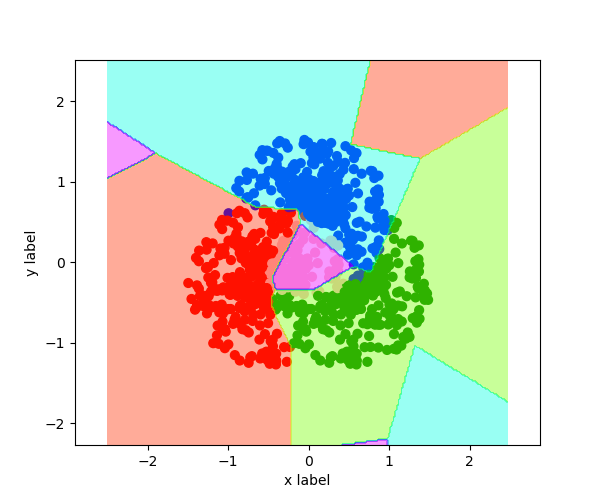

In [65]:
fig, ax = plt.subplots(figsize=(6,5)) 
x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction_with_trick)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

### Plot training error

<IPython.core.display.Javascript object>


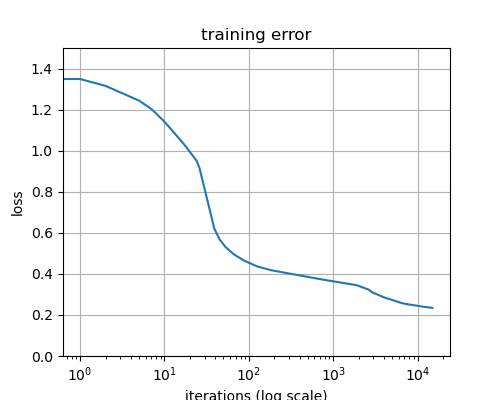

In [66]:
_x = range(len(history_with_trick))
_y = history_with_trick
xlabel = 'iterations (log scale)'
ylabel = 'loss'
title = "training error"
fig, ax = plot(_x, _y, title=title, xlabel=xlabel, ylabel=ylabel,figsize=(5,4))
ax.set_ylim(0.0, 1.5)
ax.set_xscale('log')

### Without trick

In [67]:
# W1 = np.copyto(W1, W1_backup)  # None will be set. Why not return the reference!?
W1_bias_not_0 = copy.deepcopy(W1)
W2_bias_not_0 = copy.deepcopy(W2)

W1_result_without_trick, W2_result_without_trick, objective, prediction_without_trick, history_without_trick=\
train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1_bias_not_0,
    M2=M2,
    W2=W2_bias_not_0,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.4047264104367512
iteration 100 Loss 0.7612931810655152
iteration 200 Loss 0.7309886633654702
iteration 300 Loss 0.7194182384804817
iteration 400 Loss 0.7135568958696059
iteration 500 Loss 0.7095667745521719
iteration 600 Loss 0.7065148708359619
iteration 700 Loss 0.7043282223520493
iteration 800 Loss 0.7023513093915228
iteration 900 Loss 0.7009286907746872


Iteration [946]: Loss[0.7002544025005734] has not improved from the previous [0.7002529532799133] for 1 times.
Iteration [951]: Loss[0.7002030856374671] has not improved from the previous [0.700191713764593] for 1 times.
Iteration [957]: Loss[0.7001019437657625] has not improved from the previous [0.7000999145318951] for 1 times.
Iteration [958]: Loss[0.7001129182571809] has not improved from the previous [0.7001019437657625] for 2 times.
Iteration [965]: Loss[0.7000214894544416] has not improved from the previous [0.7000019282734266] for 1 times.
Iteration [972]: Loss[0.6999325252083254] has not improved from the previous [0.6999164375959844] for 1 times.
Iteration [979]: Loss[0.6998438919862214] has not improved from the previous [0.6998283976837397] for 1 times.
Iteration [986]: Loss[0.6997537605846801] has not improved from the previous [0.6997404702167246] for 1 times.
Iteration [992]: Loss[0.6996556507196603] has not improved from the previous [0.6996535452586631] for 1 times.
It

iteration 1000 Loss 0.6995439659340246
iteration 1100 Loss 0.6985068827794376
iteration 1200 Loss 0.6973748494391855
iteration 1300 Loss 0.6964640619492016
iteration 1400 Loss 0.6958248517737289
iteration 1500 Loss 0.695281516291878
iteration 1600 Loss 0.6948002598585575
iteration 1700 Loss 0.6943132803807047
iteration 1800 Loss 0.6938034503608627
iteration 1900 Loss 0.6932738316855854
iteration 2000 Loss 0.6927041694288636
iteration 2100 Loss 0.6920608271530901
iteration 2200 Loss 0.691438281634739
iteration 2300 Loss 0.69084743394851
iteration 2400 Loss 0.6902558511997046
iteration 2500 Loss 0.689652417903566
iteration 2600 Loss 0.689029885005148
iteration 2700 Loss 0.6883772404488245
iteration 2800 Loss 0.68770019332557
iteration 2900 Loss 0.6869836857407298
iteration 3000 Loss 0.6862003624054057
iteration 3100 Loss 0.6853411522415995
iteration 3200 Loss 0.6844294678744078
iteration 3300 Loss 0.6834809652043308
iteration 3400 Loss 0.6824985680500937
iteration 3500 Loss 0.68151161731

Iteration [5744]: Loss[0.6705522896321991] has not improved from the previous [0.6705521070884197] for 1 times.


iteration 5800 Loss 0.6703871594311075
iteration 5900 Loss 0.6701064028250162


Iteration [6012]: Loss[0.6698068387240399] has not improved from the previous [0.6698060843260425] for 1 times.


iteration 6000 Loss 0.6698350665379446


Iteration [6024]: Loss[0.6697752030162044] has not improved from the previous [0.6697741796125246] for 1 times.
Iteration [6035]: Loss[0.6697466583264851] has not improved from the previous [0.6697455299023658] for 1 times.
Iteration [6054]: Loss[0.6696959778282957] has not improved from the previous [0.6696959194837542] for 1 times.
Iteration [6058]: Loss[0.6696853367149651] has not improved from the previous [0.6696846663994048] for 1 times.
Iteration [6079]: Loss[0.6696313189727827] has not improved from the previous [0.6696303443669502] for 1 times.
Iteration [6093]: Loss[0.6695939704201955] has not improved from the previous [0.6695932475908472] for 1 times.
Iteration [6097]: Loss[0.6695834544998979] has not improved from the previous [0.6695828685155819] for 1 times.


iteration 6100 Loss 0.6695730765840009


Iteration [6127]: Loss[0.6695064972078184] has not improved from the previous [0.6695051276063514] for 1 times.
Iteration [6163]: Loss[0.6694138599283694] has not improved from the previous [0.6694127725765313] for 1 times.
Iteration [6184]: Loss[0.6693599386829101] has not improved from the previous [0.6693596121945994] for 1 times.
Iteration [6204]: Loss[0.6693090524580159] has not improved from the previous [0.6693088273596984] for 1 times.


iteration 6200 Loss 0.6693160208176651


Iteration [6267]: Loss[0.6691511685314054] has not improved from the previous [0.6691500515408124] for 1 times.
Iteration [6275]: Loss[0.6691304639196584] has not improved from the previous [0.6691298247408759] for 1 times.
Iteration [6296]: Loss[0.6690781579184005] has not improved from the previous [0.6690779405280135] for 1 times.
Iteration [6315]: Loss[0.6690318086383472] has not improved from the previous [0.6690308089566058] for 1 times.


iteration 6300 Loss 0.6690653061926339


Iteration [6330]: Loss[0.6689942690992687] has not improved from the previous [0.6689941054410673] for 1 times.
Iteration [6341]: Loss[0.6689668381126863] has not improved from the previous [0.6689666720146161] for 1 times.
Iteration [6351]: Loss[0.668942828662875] has not improved from the previous [0.6689421984116359] for 1 times.
Iteration [6358]: Loss[0.6689256808697069] has not improved from the previous [0.6689246697894885] for 1 times.
Iteration [6375]: Loss[0.6688835364350728] has not improved from the previous [0.6688828273435462] for 1 times.
Iteration [6385]: Loss[0.6688587594755606] has not improved from the previous [0.6688586922955834] for 1 times.
Iteration [6392]: Loss[0.6688421459486709] has not improved from the previous [0.6688420144883587] for 1 times.
Iteration [6401]: Loss[0.6688204204983339] has not improved from the previous [0.6688196843388754] for 1 times.
Iteration [6410]: Loss[0.6687978999962934] has not improved from the previous [0.6687973939663172] for 1 

iteration 6400 Loss 0.6688196843388754


Iteration [6426]: Loss[0.6687590365687456] has not improved from the previous [0.6687587563454074] for 1 times.
Iteration [6435]: Loss[0.6687375897461647] has not improved from the previous [0.6687367303847254] for 1 times.
Iteration [6459]: Loss[0.6686799345555657] has not improved from the previous [0.6686794496098093] for 1 times.
Iteration [6468]: Loss[0.6686578178843796] has not improved from the previous [0.6686577962244922] for 1 times.
Iteration [6477]: Loss[0.6686366403636519] has not improved from the previous [0.6686358239370971] for 1 times.
Iteration [6491]: Loss[0.6686026585794642] has not improved from the previous [0.6686020829280052] for 1 times.
Iteration [6500]: Loss[0.6685816652442698] has not improved from the previous [0.66858068719387] for 1 times.
Iteration [6508]: Loss[0.6685630894758575] has not improved from the previous [0.6685620815044597] for 1 times.
Iteration [6514]: Loss[0.6685480411733038] has not improved from the previous [0.668547410002872] for 1 ti

iteration 6500 Loss 0.6685816652442698


Iteration [6531]: Loss[0.6685077689942043] has not improved from the previous [0.6685076843843765] for 1 times.
Iteration [6539]: Loss[0.6684898037200337] has not improved from the previous [0.6684891612979544] for 1 times.
Iteration [6547]: Loss[0.6684708447312613] has not improved from the previous [0.668469855206714] for 1 times.
Iteration [6552]: Loss[0.6684595479496984] has not improved from the previous [0.6684581779319282] for 1 times.
Iteration [6568]: Loss[0.6684213022742612] has not improved from the previous [0.6684209143919927] for 1 times.
Iteration [6575]: Loss[0.6684052931487673] has not improved from the previous [0.6684038151092008] for 1 times.
Iteration [6589]: Loss[0.6683722624153103] has not improved from the previous [0.6683722247635365] for 1 times.
Iteration [6596]: Loss[0.668356362777336] has not improved from the previous [0.668355025387883] for 1 times.
Iteration [6601]: Loss[0.6683453388131393] has not improved from the previous [0.6683437155603379] for 1 ti

iteration 6600 Loss 0.6683437155603379


Iteration [6631]: Loss[0.6682754318915592] has not improved from the previous [0.6682751699254147] for 1 times.
Iteration [6637]: Loss[0.668262330856813] has not improved from the previous [0.6682610414808119] for 1 times.
Iteration [6644]: Loss[0.668245777743732] has not improved from the previous [0.6682451966115417] for 1 times.
Iteration [6660]: Loss[0.6682090143360219] has not improved from the previous [0.6682087134976455] for 1 times.
Iteration [6667]: Loss[0.6681922578328375] has not improved from the previous [0.6681922268802596] for 1 times.
Iteration [6668]: Loss[0.6681942815017355] has not improved from the previous [0.6681922578328375] for 2 times.
Iteration [6680]: Loss[0.668164327500576] has not improved from the previous [0.6681638100367271] for 1 times.
Iteration [6686]: Loss[0.6681528547850186] has not improved from the previous [0.6681517771266082] for 1 times.
Iteration [6701]: Loss[0.6681178253767989] has not improved from the previous [0.6681172420907828] for 1 ti

iteration 6700 Loss 0.6681172420907828


Iteration [6721]: Loss[0.6680736387679277] has not improved from the previous [0.6680717934389383] for 1 times.
Iteration [6727]: Loss[0.6680591628415327] has not improved from the previous [0.6680589193250925] for 1 times.
Iteration [6734]: Loss[0.6680428472749963] has not improved from the previous [0.6680427130883495] for 1 times.
Iteration [6742]: Loss[0.6680252424935323] has not improved from the previous [0.6680249264075232] for 1 times.
Iteration [6761]: Loss[0.6679835499316285] has not improved from the previous [0.6679833806471688] for 1 times.
Iteration [6767]: Loss[0.6679711760582406] has not improved from the previous [0.6679711435534853] for 1 times.
Iteration [6769]: Loss[0.6679686467938775] has not improved from the previous [0.6679664949581873] for 1 times.
Iteration [6775]: Loss[0.6679551981821761] has not improved from the previous [0.6679536306254998] for 1 times.
Iteration [6777]: Loss[0.6679499266876724] has not improved from the previous [0.6679498802543974] for 1

iteration 6800 Loss 0.6678968191923128


Iteration [6808]: Loss[0.6678842722949022] has not improved from the previous [0.6678817710821764] for 1 times.
Iteration [6816]: Loss[0.667866936203221] has not improved from the previous [0.6678649649307407] for 1 times.
Iteration [6823]: Loss[0.6678509688876209] has not improved from the previous [0.667850944171348] for 1 times.
Iteration [6828]: Loss[0.6678410848040816] has not improved from the previous [0.6678390250374048] for 1 times.
Iteration [6833]: Loss[0.6678305691993285] has not improved from the previous [0.667828089351745] for 1 times.
Iteration [6841]: Loss[0.6678126682311778] has not improved from the previous [0.6678120367004713] for 1 times.
Iteration [6844]: Loss[0.667804634504087] has not improved from the previous [0.6678045534175338] for 1 times.
Iteration [6848]: Loss[0.6677979396402612] has not improved from the previous [0.66779699281457] for 1 times.
Iteration [6860]: Loss[0.6677732857556069] has not improved from the previous [0.667770488779637] for 1 times.

iteration 6900 Loss 0.66768481994393


Iteration [6934]: Loss[0.6676155511335421] has not improved from the previous [0.6676148063702684] for 1 times.
Iteration [6940]: Loss[0.6676044749880362] has not improved from the previous [0.6676014820506997] for 1 times.
Iteration [6947]: Loss[0.6675891149023447] has not improved from the previous [0.6675889050464312] for 1 times.
Iteration [6958]: Loss[0.667565852527765] has not improved from the previous [0.6675648370346919] for 1 times.
Iteration [6971]: Loss[0.6675391593947708] has not improved from the previous [0.6675378600752226] for 1 times.
Iteration [6977]: Loss[0.6675270679837025] has not improved from the previous [0.6675260392131053] for 1 times.
Iteration [6981]: Loss[0.6675186926581581] has not improved from the previous [0.6675164748252799] for 1 times.
Iteration [6994]: Loss[0.667492002114711] has not improved from the previous [0.6674904341142216] for 1 times.
Iteration [7000]: Loss[0.6674792121962031] has not improved from the previous [0.6674786413611006] for 1 t

iteration 7000 Loss 0.6674792121962031


Iteration [7011]: Loss[0.6674565693975727] has not improved from the previous [0.6674551017898892] for 1 times.
Iteration [7017]: Loss[0.6674440582538268] has not improved from the previous [0.6674439548304085] for 1 times.
Iteration [7023]: Loss[0.6674327582819599] has not improved from the previous [0.66743055756771] for 1 times.
Iteration [7030]: Loss[0.667417605086717] has not improved from the previous [0.6674167516326749] for 1 times.
Iteration [7036]: Loss[0.6674048635778763] has not improved from the previous [0.6674045055862995] for 1 times.
Iteration [7042]: Loss[0.6673926787242307] has not improved from the previous [0.6673922139720541] for 1 times.
Iteration [7048]: Loss[0.667380538301069] has not improved from the previous [0.6673798937082261] for 1 times.
Iteration [7054]: Loss[0.6673682253517947] has not improved from the previous [0.6673677863288374] for 1 times.
Iteration [7059]: Loss[0.6673569060000143] has not improved from the previous [0.6673562646291] for 1 times.

iteration 7100 Loss 0.6672721035987843


Iteration [7122]: Loss[0.6672311970344869] has not improved from the previous [0.6672299840068199] for 1 times.
Iteration [7128]: Loss[0.6672187505636255] has not improved from the previous [0.6672186902883931] for 1 times.
Iteration [7133]: Loss[0.6672092349736461] has not improved from the previous [0.6672074019912702] for 1 times.
Iteration [7139]: Loss[0.6671969919042068] has not improved from the previous [0.6671960956992931] for 1 times.
Iteration [7144]: Loss[0.6671868555707847] has not improved from the previous [0.6671854627348164] for 1 times.
Iteration [7150]: Loss[0.6671746387683793] has not improved from the previous [0.6671739578314231] for 1 times.
Iteration [7156]: Loss[0.6671624837946876] has not improved from the previous [0.6671624002360396] for 1 times.
Iteration [7161]: Loss[0.6671530612236831] has not improved from the previous [0.6671516034606962] for 1 times.
Iteration [7167]: Loss[0.6671408542887817] has not improved from the previous [0.6671401635447738] for 1

iteration 7200 Loss 0.6670752250095998


Iteration [7211]: Loss[0.6670531037401298] has not improved from the previous [0.6670530307376341] for 1 times.
Iteration [7216]: Loss[0.667043336443366] has not improved from the previous [0.6670419651849082] for 1 times.
Iteration [7221]: Loss[0.6670338041785674] has not improved from the previous [0.6670318465974389] for 1 times.
Iteration [7227]: Loss[0.6670214189816144] has not improved from the previous [0.6670208135380064] for 1 times.
Iteration [7232]: Loss[0.6670116286189013] has not improved from the previous [0.6670109062413337] for 1 times.
Iteration [7237]: Loss[0.6670016964012441] has not improved from the previous [0.6670012044729714] for 1 times.
Iteration [7242]: Loss[0.666992098285606] has not improved from the previous [0.6669901056496597] for 1 times.
Iteration [7253]: Loss[0.6669701302274011] has not improved from the previous [0.6669694123475606] for 1 times.
Iteration [7258]: Loss[0.6669599942898835] has not improved from the previous [0.6669598442913579] for 1 t

iteration 7300 Loss 0.6668743116721022


Iteration [7308]: Loss[0.6668611922381947] has not improved from the previous [0.6668605090052862] for 1 times.
Iteration [7313]: Loss[0.6668517779016234] has not improved from the previous [0.6668509204828031] for 1 times.
Iteration [7318]: Loss[0.6668421659818844] has not improved from the previous [0.6668415658211303] for 1 times.
Iteration [7332]: Loss[0.6668141566998509] has not improved from the previous [0.6668128599857508] for 1 times.
Iteration [7337]: Loss[0.666804559658341] has not improved from the previous [0.6668035195336185] for 1 times.
Iteration [7342]: Loss[0.6667944438903695] has not improved from the previous [0.6667941906682985] for 1 times.
Iteration [7356]: Loss[0.666766956386478] has not improved from the previous [0.6667659849682127] for 1 times.
Iteration [7361]: Loss[0.6667572728740487] has not improved from the previous [0.6667565552206843] for 1 times.
Iteration [7375]: Loss[0.666729615169776] has not improved from the previous [0.6667289762479772] for 1 ti

iteration 7400 Loss 0.6666790343060169


Iteration [7434]: Loss[0.6666147230772371] has not improved from the previous [0.6666143182600397] for 1 times.
Iteration [7443]: Loss[0.6665970661631905] has not improved from the previous [0.6665966882988783] for 1 times.
Iteration [7453]: Loss[0.6665783907021349] has not improved from the previous [0.6665767398445658] for 1 times.
Iteration [7462]: Loss[0.6665602247089726] has not improved from the previous [0.6665599053141698] for 1 times.
Iteration [7482]: Loss[0.6665214556361458] has not improved from the previous [0.6665208869260155] for 1 times.
Iteration [7486]: Loss[0.6665137094265976] has not improved from the previous [0.666512749977744] for 1 times.
Iteration [7496]: Loss[0.6664944859996641] has not improved from the previous [0.6664938248762373] for 1 times.
Iteration [7506]: Loss[0.6664748098219838] has not improved from the previous [0.6664743509503795] for 1 times.
Iteration [7510]: Loss[0.6664672224329281] has not improved from the previous [0.6664662868294687] for 1 

iteration 7500 Loss 0.6664853204007805


Iteration [7524]: Loss[0.6664402436149341] has not improved from the previous [0.6664390298137911] for 1 times.
Iteration [7528]: Loss[0.6664316060147484] has not improved from the previous [0.6664313471563187] for 1 times.
Iteration [7534]: Loss[0.6664214976778928] has not improved from the previous [0.6664214383231001] for 1 times.
Iteration [7547]: Loss[0.6663966843577023] has not improved from the previous [0.6663962189269986] for 1 times.
Iteration [7556]: Loss[0.6663786085967379] has not improved from the previous [0.6663776960172956] for 1 times.
Iteration [7574]: Loss[0.6663456185117198] has not improved from the previous [0.6663440028176842] for 1 times.
Iteration [7592]: Loss[0.6663090613581025] has not improved from the previous [0.6663089467241448] for 1 times.
Iteration [7596]: Loss[0.6663021137628127] has not improved from the previous [0.6663015310706621] for 1 times.
Iteration [7597]: Loss[0.6663023105324897] has not improved from the previous [0.6663021137628127] for 2

iteration 7600 Loss 0.6662944252662673


Iteration [7616]: Loss[0.6662656019069271] has not improved from the previous [0.6662636071317026] for 1 times.
Iteration [7620]: Loss[0.6662575256096868] has not improved from the previous [0.6662562443947787] for 1 times.
Iteration [7625]: Loss[0.6662494251876999] has not improved from the previous [0.6662482777200348] for 1 times.
Iteration [7629]: Loss[0.6662412210138379] has not improved from the previous [0.6662399975332363] for 1 times.
Iteration [7638]: Loss[0.6662222662845764] has not improved from the previous [0.666222133675722] for 1 times.
Iteration [7643]: Loss[0.6662145996221096] has not improved from the previous [0.6662131081959403] for 1 times.
Iteration [7647]: Loss[0.6662069266527416] has not improved from the previous [0.6662064730228675] for 1 times.
Iteration [7655]: Loss[0.6661920867032777] has not improved from the previous [0.6661908150992383] for 1 times.
Iteration [7659]: Loss[0.6661855849504134] has not improved from the previous [0.6661843326876724] for 1 

iteration 7700 Loss 0.6661042361115956


Iteration [7706]: Loss[0.6660964521248512] has not improved from the previous [0.6660959049640183] for 1 times.
Iteration [7710]: Loss[0.6660889828866721] has not improved from the previous [0.6660881636813792] for 1 times.
Iteration [7714]: Loss[0.6660813623763493] has not improved from the previous [0.6660809823436329] for 1 times.
Iteration [7717]: Loss[0.6660744409215931] has not improved from the previous [0.6660738919194157] for 1 times.
Iteration [7718]: Loss[0.6660750093523687] has not improved from the previous [0.6660744409215931] for 2 times.
Iteration [7722]: Loss[0.6660666313295909] has not improved from the previous [0.6660656738347777] for 1 times.
Iteration [7726]: Loss[0.6660581216610544] has not improved from the previous [0.6660571020047656] for 1 times.
Iteration [7731]: Loss[0.6660497835689896] has not improved from the previous [0.6660490695308355] for 1 times.
Iteration [7738]: Loss[0.6660368919923398] has not improved from the previous [0.6660356971915037] for 1

iteration 7800 Loss 0.6659200738449466


Iteration [7814]: Loss[0.6658966486592379] has not improved from the previous [0.665895886692994] for 1 times.
Iteration [7825]: Loss[0.6658772578793107] has not improved from the previous [0.6658752007464609] for 1 times.
Iteration [7828]: Loss[0.6658710794791438] has not improved from the previous [0.6658696121896078] for 1 times.
Iteration [7833]: Loss[0.6658627357588482] has not improved from the previous [0.6658615717352431] for 1 times.
Iteration [7845]: Loss[0.6658401265335903] has not improved from the previous [0.6658392096912635] for 1 times.
Iteration [7848]: Loss[0.6658333250622939] has not improved from the previous [0.6658330330670776] for 1 times.
Iteration [7856]: Loss[0.665820702626378] has not improved from the previous [0.6658185906034494] for 1 times.
Iteration [7867]: Loss[0.6658000305567028] has not improved from the previous [0.6657985067498696] for 1 times.
Iteration [7875]: Loss[0.6657857669734535] has not improved from the previous [0.6657847553789734] for 1 t

iteration 7900 Loss 0.6657367007485352


Iteration [7918]: Loss[0.6657074261538394] has not improved from the previous [0.6657067927742981] for 1 times.
Iteration [7929]: Loss[0.665686921155418] has not improved from the previous [0.6656858029773622] for 1 times.
Iteration [7932]: Loss[0.6656808913095329] has not improved from the previous [0.6656806408087775] for 1 times.
Iteration [7936]: Loss[0.6656733923942442] has not improved from the previous [0.6656729614415318] for 1 times.
Iteration [7940]: Loss[0.6656670064029007] has not improved from the previous [0.6656668141723431] for 1 times.
Iteration [7943]: Loss[0.6656605424790952] has not improved from the previous [0.6656599302309661] for 1 times.
Iteration [7952]: Loss[0.6656451753781639] has not improved from the previous [0.6656450696296283] for 1 times.
Iteration [7955]: Loss[0.6656388600177751] has not improved from the previous [0.6656380292031195] for 1 times.
Iteration [7964]: Loss[0.66562392189061] has not improved from the previous [0.6656229572939072] for 1 ti

iteration 8000 Loss 0.6655550944251385


Iteration [8017]: Loss[0.6655271421647508] has not improved from the previous [0.6655263240870125] for 1 times.
Iteration [8020]: Loss[0.665520693396466] has not improved from the previous [0.6655203856593532] for 1 times.
Iteration [8028]: Loss[0.6655074746187046] has not improved from the previous [0.665506260242314] for 1 times.
Iteration [8031]: Loss[0.6655006705260765] has not improved from the previous [0.6655001702865413] for 1 times.
Iteration [8040]: Loss[0.665485834953315] has not improved from the previous [0.6654845644580907] for 1 times.
Iteration [8043]: Loss[0.665479060067053] has not improved from the previous [0.6654785422637597] for 1 times.
Iteration [8047]: Loss[0.6654718999074235] has not improved from the previous [0.6654711983323294] for 1 times.
Iteration [8051]: Loss[0.6654652025954055] has not improved from the previous [0.6654651646600425] for 1 times.
Iteration [8054]: Loss[0.6654606525342873] has not improved from the previous [0.6654587736124606] for 1 tim

iteration 8100 Loss 0.6653746757177625


Iteration [8126]: Loss[0.6653298425408171] has not improved from the previous [0.6653282446376496] for 1 times.
Iteration [8129]: Loss[0.6653251415577887] has not improved from the previous [0.6653222362891318] for 1 times.
Iteration [8140]: Loss[0.6653037470834418] has not improved from the previous [0.6653033081606305] for 1 times.
Iteration [8143]: Loss[0.6652993050489224] has not improved from the previous [0.665297177201952] for 1 times.
Iteration [8151]: Loss[0.665284790182752] has not improved from the previous [0.6652836863101415] for 1 times.
Iteration [8155]: Loss[0.6652764560739616] has not improved from the previous [0.665276175086866] for 1 times.
Iteration [8158]: Loss[0.6652714629909935] has not improved from the previous [0.6652699758999248] for 1 times.
Iteration [8170]: Loss[0.6652500127866356] has not improved from the previous [0.665248581027831] for 1 times.
Iteration [8173]: Loss[0.6652442246882814] has not improved from the previous [0.6652430209619122] for 1 tim

iteration 8200 Loss 0.66519455749187


Iteration [8209]: Loss[0.6651775790688138] has not improved from the previous [0.6651774853818037] for 1 times.
Iteration [8213]: Loss[0.6651699894153709] has not improved from the previous [0.6651695043578049] for 1 times.
Iteration [8217]: Loss[0.6651637263008445] has not improved from the previous [0.6651628736147724] for 1 times.
Iteration [8220]: Loss[0.6651586359078305] has not improved from the previous [0.6651571743752763] for 1 times.
Iteration [8223]: Loss[0.665152192681198] has not improved from the previous [0.6651517100363205] for 1 times.
Iteration [8227]: Loss[0.6651445780919601] has not improved from the previous [0.6651438429138865] for 1 times.
Iteration [8239]: Loss[0.6651234556342849] has not improved from the previous [0.6651225706221504] for 1 times.
Iteration [8242]: Loss[0.66511928227627] has not improved from the previous [0.6651177278895334] for 1 times.
Iteration [8245]: Loss[0.665112063866186] has not improved from the previous [0.665111923953437] for 1 time

iteration 8300 Loss 0.6650127876174183


Iteration [8315]: Loss[0.6649841356659778] has not improved from the previous [0.6649835803387547] for 1 times.
Iteration [8318]: Loss[0.6649783020926872] has not improved from the previous [0.6649778157548858] for 1 times.
Iteration [8319]: Loss[0.6649805858513145] has not improved from the previous [0.6649783020926872] for 2 times.
Iteration [8322]: Loss[0.6649711439729038] has not improved from the previous [0.6649708469843048] for 1 times.
Iteration [8325]: Loss[0.6649659881672659] has not improved from the previous [0.6649654790634009] for 1 times.
Iteration [8329]: Loss[0.6649620389389022] has not improved from the previous [0.6649607852298145] for 1 times.
Iteration [8332]: Loss[0.6649549062205556] has not improved from the previous [0.6649537382030015] for 1 times.
Iteration [8335]: Loss[0.6649494438478385] has not improved from the previous [0.6649487276644271] for 1 times.
Iteration [8338]: Loss[0.6649445440831386] has not improved from the previous [0.664942496213476] for 1 

iteration 8400 Loss 0.6648327988726975


Iteration [8418]: Loss[0.6648034579239632] has not improved from the previous [0.6648006614357642] for 1 times.
Iteration [8421]: Loss[0.6647970868084468] has not improved from the previous [0.664795052025263] for 1 times.
Iteration [8425]: Loss[0.6647907374134308] has not improved from the previous [0.6647882355403664] for 1 times.
Iteration [8428]: Loss[0.6647859353154278] has not improved from the previous [0.6647829039666169] for 1 times.
Iteration [8431]: Loss[0.6647781613641894] has not improved from the previous [0.6647772198830588] for 1 times.
Iteration [8435]: Loss[0.6647732092197849] has not improved from the previous [0.664770601160327] for 1 times.
Iteration [8438]: Loss[0.6647665029141681] has not improved from the previous [0.6647663319217295] for 1 times.
Iteration [8442]: Loss[0.6647595032091502] has not improved from the previous [0.6647591713593215] for 1 times.
Iteration [8450]: Loss[0.6647460655945792] has not improved from the previous [0.6647455835982805] for 1 t

iteration 8500 Loss 0.6646568998929301


Iteration [8520]: Loss[0.6646198371850566] has not improved from the previous [0.6646196543581862] for 1 times.
Iteration [8527]: Loss[0.664606853103153] has not improved from the previous [0.6646063346354221] for 1 times.
Iteration [8528]: Loss[0.6646070276512132] has not improved from the previous [0.664606853103153] for 2 times.
Iteration [8531]: Loss[0.6646025658258845] has not improved from the previous [0.6645996776786964] for 1 times.
Iteration [8537]: Loss[0.6645915082765818] has not improved from the previous [0.6645886034907169] for 1 times.
Iteration [8544]: Loss[0.6645763271737151] has not improved from the previous [0.6645760477940811] for 1 times.
Iteration [8545]: Loss[0.6645765387980802] has not improved from the previous [0.6645763271737151] for 2 times.
Iteration [8548]: Loss[0.6645710924211754] has not improved from the previous [0.664569293443219] for 1 times.
Iteration [8552]: Loss[0.664564983519025] has not improved from the previous [0.6645619371364933] for 1 tim

iteration 8600 Loss 0.6644778120750907


Iteration [8613]: Loss[0.6644523084442016] has not improved from the previous [0.6644521362277344] for 1 times.
Iteration [8617]: Loss[0.6644468155030351] has not improved from the previous [0.6644466866570266] for 1 times.
Iteration [8621]: Loss[0.6644397196167324] has not improved from the previous [0.6644390130723717] for 1 times.
Iteration [8624]: Loss[0.6644345344597119] has not improved from the previous [0.6644320804468765] for 1 times.
Iteration [8627]: Loss[0.6644280951892418] has not improved from the previous [0.6644263279429453] for 1 times.
Iteration [8630]: Loss[0.6644224678817612] has not improved from the previous [0.6644218493237729] for 1 times.
Iteration [8635]: Loss[0.6644145648309776] has not improved from the previous [0.6644136686268205] for 1 times.
Iteration [8638]: Loss[0.6644108902811879] has not improved from the previous [0.664406548486808] for 1 times.
Iteration [8641]: Loss[0.6644033103743774] has not improved from the previous [0.6644018364544082] for 1 

iteration 8700 Loss 0.6642978071958077


Iteration [8704]: Loss[0.6642941853594815] has not improved from the previous [0.664292852753805] for 1 times.
Iteration [8711]: Loss[0.6642824342105222] has not improved from the previous [0.6642803760713475] for 1 times.
Iteration [8714]: Loss[0.6642772554998783] has not improved from the previous [0.6642754558471525] for 1 times.
Iteration [8718]: Loss[0.6642701035901492] has not improved from the previous [0.6642694372832854] for 1 times.
Iteration [8721]: Loss[0.6642640169941966] has not improved from the previous [0.6642630264261494] for 1 times.
Iteration [8725]: Loss[0.664258230393177] has not improved from the previous [0.6642568878768831] for 1 times.
Iteration [8728]: Loss[0.6642516470873744] has not improved from the previous [0.6642511430774136] for 1 times.
Iteration [8732]: Loss[0.6642463178937659] has not improved from the previous [0.6642446421550947] for 1 times.
Iteration [8735]: Loss[0.6642394000531423] has not improved from the previous [0.6642392630634107] for 1 t

iteration 8800 Loss 0.664129165982877


Iteration [8811]: Loss[0.664110970650281] has not improved from the previous [0.6641101980162968] for 1 times.
Iteration [8817]: Loss[0.6641001580341546] has not improved from the previous [0.6640989736688588] for 1 times.
Iteration [8821]: Loss[0.6640938879581164] has not improved from the previous [0.6640931650029576] for 1 times.
Iteration [8824]: Loss[0.6640882226313594] has not improved from the previous [0.6640868493667768] for 1 times.
Iteration [8828]: Loss[0.6640818841621655] has not improved from the previous [0.6640813069580536] for 1 times.
Iteration [8834]: Loss[0.6640725125372657] has not improved from the previous [0.6640699421441111] for 1 times.
Iteration [8837]: Loss[0.6640668209896187] has not improved from the previous [0.6640653502349705] for 1 times.
Iteration [8840]: Loss[0.6640614763852517] has not improved from the previous [0.66406073138883] for 1 times.
Iteration [8843]: Loss[0.6640555986321912] has not improved from the previous [0.6640545041305336] for 1 ti

iteration 8900 Loss 0.663956045101562


Iteration [8904]: Loss[0.6639520973508067] has not improved from the previous [0.6639514352523105] for 1 times.
Iteration [8907]: Loss[0.6639464141414723] has not improved from the previous [0.6639450346032273] for 1 times.
Iteration [8911]: Loss[0.6639402577839694] has not improved from the previous [0.6639392197762632] for 1 times.
Iteration [8914]: Loss[0.6639342970085323] has not improved from the previous [0.6639330996155637] for 1 times.
Iteration [8918]: Loss[0.6639283830827549] has not improved from the previous [0.6639273900779724] for 1 times.
Iteration [8921]: Loss[0.6639228442408821] has not improved from the previous [0.6639227722056656] for 1 times.
Iteration [8924]: Loss[0.6639185539278822] has not improved from the previous [0.6639160754765108] for 1 times.
Iteration [8927]: Loss[0.6639130734285883] has not improved from the previous [0.6639116877006839] for 1 times.
Iteration [8930]: Loss[0.6639063798286665] has not improved from the previous [0.6639059617866541] for 1

iteration 9000 Loss 0.6637840295496291


Iteration [9007]: Loss[0.6637744964893434] has not improved from the previous [0.6637739503217662] for 1 times.
Iteration [9011]: Loss[0.6637691695072854] has not improved from the previous [0.6637676930426943] for 1 times.
Iteration [9014]: Loss[0.6637636115452298] has not improved from the previous [0.6637631040324793] for 1 times.
Iteration [9017]: Loss[0.6637578921613192] has not improved from the previous [0.6637566869069735] for 1 times.
Iteration [9021]: Loss[0.6637515403351253] has not improved from the previous [0.6637510470857427] for 1 times.
Iteration [9024]: Loss[0.6637459848699209] has not improved from the previous [0.6637444874506043] for 1 times.
Iteration [9028]: Loss[0.6637395826502817] has not improved from the previous [0.6637391811011378] for 1 times.
Iteration [9031]: Loss[0.6637351370229873] has not improved from the previous [0.6637325215793332] for 1 times.
Iteration [9034]: Loss[0.663729593506185] has not improved from the previous [0.663728265596887] for 1 t

iteration 9100 Loss 0.6636163317519096


Iteration [9106]: Loss[0.6636040127330414] has not improved from the previous [0.663603600432744] for 1 times.
Iteration [9110]: Loss[0.6635986434056378] has not improved from the previous [0.6635972427025199] for 1 times.
Iteration [9113]: Loss[0.6635928279815966] has not improved from the previous [0.6635913101665765] for 1 times.
Iteration [9117]: Loss[0.6635866007801895] has not improved from the previous [0.663585242674953] for 1 times.
Iteration [9120]: Loss[0.663580327432053] has not improved from the previous [0.6635793469823538] for 1 times.
Iteration [9124]: Loss[0.6635743235606182] has not improved from the previous [0.6635735133986104] for 1 times.
Iteration [9127]: Loss[0.6635688999765321] has not improved from the previous [0.6635668817055755] for 1 times.
Iteration [9131]: Loss[0.6635620688941484] has not improved from the previous [0.6635615545440515] for 1 times.
Iteration [9134]: Loss[0.6635578355757319] has not improved from the previous [0.6635551332309159] for 1 ti

iteration 9200 Loss 0.6634421482185436


Iteration [9210]: Loss[0.6634253881819648] has not improved from the previous [0.6634244664363738] for 1 times.
Iteration [9213]: Loss[0.6634195460470601] has not improved from the previous [0.6634181800881102] for 1 times.
Iteration [9217]: Loss[0.6634130512359343] has not improved from the previous [0.6634127553241125] for 1 times.
Iteration [9220]: Loss[0.6634085263162366] has not improved from the previous [0.6634063743104028] for 1 times.
Iteration [9223]: Loss[0.6634030409903588] has not improved from the previous [0.6634016696329644] for 1 times.
Iteration [9226]: Loss[0.6633965507998876] has not improved from the previous [0.6633957177824844] for 1 times.
Iteration [9230]: Loss[0.6633905911618238] has not improved from the previous [0.6633897684625113] for 1 times.
Iteration [9232]: Loss[0.6633856064528946] has not improved from the previous [0.6633854450173223] for 1 times.
Iteration [9236]: Loss[0.6633807931698315] has not improved from the previous [0.6633783869248272] for 1

iteration 9300 Loss 0.6632665942658406


Iteration [9322]: Loss[0.6632314127896467] has not improved from the previous [0.6632280614659366] for 1 times.
Iteration [9325]: Loss[0.6632253623715556] has not improved from the previous [0.6632237896922674] for 1 times.
Iteration [9328]: Loss[0.663218516175384] has not improved from the previous [0.6632181111944004] for 1 times.
Iteration [9332]: Loss[0.6632129601281477] has not improved from the previous [0.6632117659203666] for 1 times.
Iteration [9335]: Loss[0.6632067130863861] has not improved from the previous [0.6632057036822924] for 1 times.
Iteration [9339]: Loss[0.6632005305495638] has not improved from the previous [0.6631999541573419] for 1 times.
Iteration [9342]: Loss[0.6631960997288227] has not improved from the previous [0.6631934157731937] for 1 times.
Iteration [9345]: Loss[0.6631902912385581] has not improved from the previous [0.6631895171584283] for 1 times.
Iteration [9348]: Loss[0.6631844391120605] has not improved from the previous [0.6631829951364938] for 1 

iteration 9400 Loss 0.663089987892425


Iteration [9408]: Loss[0.6630802716228141] has not improved from the previous [0.6630777627769407] for 1 times.
Iteration [9411]: Loss[0.6630744280342364] has not improved from the previous [0.6630732966204345] for 1 times.
Iteration [9414]: Loss[0.663068026976978] has not improved from the previous [0.6630671967735223] for 1 times.
Iteration [9418]: Loss[0.66306211125878] has not improved from the previous [0.6630612781071803] for 1 times.
Iteration [9421]: Loss[0.6630575050698355] has not improved from the previous [0.6630547442459382] for 1 times.
Iteration [9424]: Loss[0.663051645228083] has not improved from the previous [0.6630502789692321] for 1 times.
Iteration [9427]: Loss[0.6630450105570335] has not improved from the previous [0.6630443603929105] for 1 times.
Iteration [9431]: Loss[0.6630393203213474] has not improved from the previous [0.6630382656095202] for 1 times.
Iteration [9434]: Loss[0.6630333905312771] has not improved from the previous [0.6630317650239113] for 1 tim

iteration 9500 Loss 0.6629183609259878


Iteration [9516]: Loss[0.6628910766484514] has not improved from the previous [0.6628890465142494] for 1 times.
Iteration [9519]: Loss[0.662885393889716] has not improved from the previous [0.6628846225642946] for 1 times.
Iteration [9522]: Loss[0.6628789686112321] has not improved from the previous [0.6628783391186526] for 1 times.
Iteration [9526]: Loss[0.6628731799124842] has not improved from the previous [0.662871999088478] for 1 times.
Iteration [9529]: Loss[0.6628670933142883] has not improved from the previous [0.6628656192490542] for 1 times.
Iteration [9533]: Loss[0.662860711022178] has not improved from the previous [0.6628600353486486] for 1 times.
Iteration [9536]: Loss[0.6628561915397391] has not improved from the previous [0.6628533689823556] for 1 times.
Iteration [9539]: Loss[0.6628505305582818] has not improved from the previous [0.6628488823477446] for 1 times.
Iteration [9542]: Loss[0.6628442888857524] has not improved from the previous [0.6628430087916426] for 1 ti

iteration 9600 Loss 0.6627409483707968


Iteration [9616]: Loss[0.6627159565769435] has not improved from the previous [0.6627140569857704] for 1 times.
Iteration [9619]: Loss[0.6627106712046368] has not improved from the previous [0.6627092521122371] for 1 times.
Iteration [9622]: Loss[0.6627046067107752] has not improved from the previous [0.6627026492499137] for 1 times.
Iteration [9626]: Loss[0.6626977460690745] has not improved from the previous [0.6626974505997828] for 1 times.
Iteration [9629]: Loss[0.6626925795797259] has not improved from the previous [0.6626907077421539] for 1 times.
Iteration [9633]: Loss[0.6626859559774951] has not improved from the previous [0.6626848007510541] for 1 times.
Iteration [9636]: Loss[0.6626805673163386] has not improved from the previous [0.662679981330356] for 1 times.
Iteration [9639]: Loss[0.6626764236439691] has not improved from the previous [0.6626729457381487] for 1 times.
Iteration [9642]: Loss[0.6626703209984082] has not improved from the previous [0.6626684079780732] for 1 

iteration 9700 Loss 0.6625673638539251


Iteration [9710]: Loss[0.6625501134868881] has not improved from the previous [0.6625484190437149] for 1 times.
Iteration [9714]: Loss[0.6625437298715448] has not improved from the previous [0.6625429488833328] for 1 times.
Iteration [9717]: Loss[0.6625375812409318] has not improved from the previous [0.6625362706247071] for 1 times.
Iteration [9721]: Loss[0.6625312241449051] has not improved from the previous [0.6625305728241696] for 1 times.
Iteration [9727]: Loss[0.6625204530747333] has not improved from the previous [0.6625185312542974] for 1 times.
Iteration [9731]: Loss[0.6625134847937522] has not improved from the previous [0.6625134314236607] for 1 times.
Iteration [9734]: Loss[0.662509381435932] has not improved from the previous [0.6625068096980343] for 1 times.
Iteration [9737]: Loss[0.6625036340670653] has not improved from the previous [0.6625021409676288] for 1 times.
Iteration [9740]: Loss[0.6624985106652106] has not improved from the previous [0.6624966154928105] for 1 

iteration 9800 Loss 0.6623893480932347


Iteration [9818]: Loss[0.6623608814434369] has not improved from the previous [0.6623585624460766] for 1 times.
Iteration [9822]: Loss[0.6623543155849578] has not improved from the previous [0.6623528460793039] for 1 times.
Iteration [9825]: Loss[0.6623486503539472] has not improved from the previous [0.6623462711162968] for 1 times.
Iteration [9829]: Loss[0.6623421600346304] has not improved from the previous [0.6623406779272086] for 1 times.
Iteration [9832]: Loss[0.662336324171416] has not improved from the previous [0.6623359299675056] for 1 times.
Iteration [9835]: Loss[0.662331854893226] has not improved from the previous [0.6623292818395474] for 1 times.
Iteration [9838]: Loss[0.6623263534186244] has not improved from the previous [0.6623248896166931] for 1 times.
Iteration [9841]: Loss[0.6623213170236797] has not improved from the previous [0.6623191827909777] for 1 times.
Iteration [9844]: Loss[0.6623154569947407] has not improved from the previous [0.6623144744602314] for 1 t

iteration 9900 Loss 0.6622167416010108


Iteration [9906]: Loss[0.6622066831834389] has not improved from the previous [0.6622060110827142] for 1 times.
Iteration [9909]: Loss[0.6622012691045773] has not improved from the previous [0.6622002349333245] for 1 times.
Iteration [9912]: Loss[0.6621954121863076] has not improved from the previous [0.6621939016798124] for 1 times.
Iteration [9916]: Loss[0.6621889481457937] has not improved from the previous [0.6621877750414045] for 1 times.
Iteration [9922]: Loss[0.6621781945333152] has not improved from the previous [0.6621758064053204] for 1 times.
Iteration [9926]: Loss[0.6621718714036129] has not improved from the previous [0.6621701303895187] for 1 times.
Iteration [9932]: Loss[0.6621617389430523] has not improved from the previous [0.6621590688228055] for 1 times.
Iteration [9935]: Loss[0.6621560324047929] has not improved from the previous [0.6621536705363676] for 1 times.
Iteration [9938]: Loss[0.6621500723290421] has not improved from the previous [0.6621492410102781] for 1

iteration 10000 Loss 0.6620376136182271


Iteration [10009]: Loss[0.6620253816208146] has not improved from the previous [0.6620244821339926] for 1 times.
Iteration [10012]: Loss[0.6620197569059818] has not improved from the previous [0.662019050902514] for 1 times.
Iteration [10015]: Loss[0.6620154456457901] has not improved from the previous [0.6620127981521748] for 1 times.
Iteration [10018]: Loss[0.6620098739827742] has not improved from the previous [0.6620072733592429] for 1 times.
Iteration [10021]: Loss[0.6620038013425894] has not improved from the previous [0.6620030969705799] for 1 times.
Iteration [10024]: Loss[0.661997685445886] has not improved from the previous [0.6619966750581433] for 1 times.
Iteration [10028]: Loss[0.6619920524166716] has not improved from the previous [0.6619907095247437] for 1 times.
Iteration [10031]: Loss[0.6619863293667452] has not improved from the previous [0.6619853392536049] for 1 times.
Iteration [10034]: Loss[0.6619802414981664] has not improved from the previous [0.6619790740265551

iteration 10100 Loss 0.661861269612455


Iteration [10110]: Loss[0.6618466310006509] has not improved from the previous [0.6618443757417161] for 1 times.
Iteration [10113]: Loss[0.6618405029561362] has not improved from the previous [0.6618391411442214] for 1 times.
Iteration [10116]: Loss[0.6618355505731833] has not improved from the previous [0.6618341867003076] for 1 times.
Iteration [10119]: Loss[0.6618294389928541] has not improved from the previous [0.6618290116014873] for 1 times.
Iteration [10122]: Loss[0.6618237146645068] has not improved from the previous [0.6618221349483623] for 1 times.
Iteration [10126]: Loss[0.6618177327384597] has not improved from the previous [0.661816360743582] for 1 times.
Iteration [10132]: Loss[0.6618078222688436] has not improved from the previous [0.6618043925722226] for 1 times.
Iteration [10135]: Loss[0.661801457729199] has not improved from the previous [0.6617995247864279] for 1 times.
Iteration [10138]: Loss[0.6617964810319599] has not improved from the previous [0.6617947268571622

iteration 10200 Loss 0.6616850807208479


Iteration [10207]: Loss[0.6616729658169187] has not improved from the previous [0.6616719293839497] for 1 times.
Iteration [10209]: Loss[0.6616672690386918] has not improved from the previous [0.6616671611557162] for 1 times.
Iteration [10213]: Loss[0.6616629155013025] has not improved from the previous [0.661660195779771] for 1 times.
Iteration [10216]: Loss[0.6616563072386298] has not improved from the previous [0.6616556493758631] for 1 times.
Iteration [10219]: Loss[0.6616515264441345] has not improved from the previous [0.6616505985399627] for 1 times.
Iteration [10222]: Loss[0.6616462749282717] has not improved from the previous [0.6616437926415739] for 1 times.
Iteration [10225]: Loss[0.6616413766431873] has not improved from the previous [0.6616389957625496] for 1 times.
Iteration [10228]: Loss[0.6616348038948251] has not improved from the previous [0.6616343082612964] for 1 times.
Iteration [10231]: Loss[0.6616296263230849] has not improved from the previous [0.661628836353776

iteration 10300 Loss 0.6615029592378692


Iteration [10312]: Loss[0.6614858798457952] has not improved from the previous [0.6614833169920628] for 1 times.
Iteration [10315]: Loss[0.6614791567435815] has not improved from the previous [0.6614788759645881] for 1 times.
Iteration [10318]: Loss[0.6614738860244678] has not improved from the previous [0.6614735808108337] for 1 times.
Iteration [10321]: Loss[0.6614697719698868] has not improved from the previous [0.6614671440655611] for 1 times.
Iteration [10324]: Loss[0.6614631726825227] has not improved from the previous [0.6614625431112171] for 1 times.
Iteration [10327]: Loss[0.6614583458420901] has not improved from the previous [0.6614577300686239] for 1 times.
Iteration [10330]: Loss[0.6614528474453997] has not improved from the previous [0.6614510803338618] for 1 times.
Iteration [10333]: Loss[0.6614473861845579] has not improved from the previous [0.6614460191133356] for 1 times.
Iteration [10336]: Loss[0.6614422024502027] has not improved from the previous [0.66144162171797

iteration 10400 Loss 0.661325049271946


Iteration [10413]: Loss[0.6613043454744387] has not improved from the previous [0.6613020543702429] for 1 times.
Iteration [10416]: Loss[0.6612989493518301] has not improved from the previous [0.6612979230074147] for 1 times.
Iteration [10419]: Loss[0.6612934871677207] has not improved from the previous [0.6612912604649598] for 1 times.
Iteration [10422]: Loss[0.6612884263159541] has not improved from the previous [0.6612867174580195] for 1 times.
Iteration [10425]: Loss[0.6612829232959032] has not improved from the previous [0.6612802930703815] for 1 times.
Iteration [10428]: Loss[0.6612772573631415] has not improved from the previous [0.6612753501076715] for 1 times.
Iteration [10431]: Loss[0.6612720731619974] has not improved from the previous [0.6612709622931577] for 1 times.
Iteration [10434]: Loss[0.6612664766111431] has not improved from the previous [0.6612643409313259] for 1 times.
Iteration [10437]: Loss[0.661260966468726] has not improved from the previous [0.661259444068140

iteration 10500 Loss 0.6611438024396237


Iteration [10508]: Loss[0.6611334736612352] has not improved from the previous [0.6611330680896352] for 1 times.
Iteration [10511]: Loss[0.6611277831591262] has not improved from the previous [0.6611265769634666] for 1 times.
Iteration [10514]: Loss[0.6611222290370006] has not improved from the previous [0.661121773988989] for 1 times.
Iteration [10517]: Loss[0.6611179435396242] has not improved from the previous [0.6611155260538432] for 1 times.
Iteration [10523]: Loss[0.6611067468445796] has not improved from the previous [0.6611042371603946] for 1 times.
Iteration [10526]: Loss[0.6611013047881633] has not improved from the previous [0.6611002585365707] for 1 times.
Iteration [10529]: Loss[0.6610956358838201] has not improved from the previous [0.6610937829600108] for 1 times.
Iteration [10532]: Loss[0.6610900289223278] has not improved from the previous [0.6610890183660671] for 1 times.
Iteration [10535]: Loss[0.6610857532379186] has not improved from the previous [0.661082797910233

iteration 10600 Loss 0.6609655843287798


Iteration [10611]: Loss[0.6609479720952581] has not improved from the previous [0.6609469210396997] for 1 times.
Iteration [10614]: Loss[0.6609436813457928] has not improved from the previous [0.6609407341555396] for 1 times.
Iteration [10617]: Loss[0.6609369267660249] has not improved from the previous [0.6609366841723013] for 1 times.
Iteration [10620]: Loss[0.6609322029100897] has not improved from the previous [0.6609297575536722] for 1 times.
Iteration [10623]: Loss[0.6609269036389815] has not improved from the previous [0.6609257730290821] for 1 times.
Iteration [10626]: Loss[0.6609210788062717] has not improved from the previous [0.6609195141737347] for 1 times.
Iteration [10629]: Loss[0.6609152138657282] has not improved from the previous [0.6609131009423428] for 1 times.
Iteration [10632]: Loss[0.6609086447307656] has not improved from the previous [0.6609081890009278] for 1 times.
Iteration [10636]: Loss[0.6609028881525711] has not improved from the previous [0.66090190882346

iteration 10700 Loss 0.6607849231557291


Iteration [10714]: Loss[0.6607621979840703] has not improved from the previous [0.660761000991361] for 1 times.
Iteration [10717]: Loss[0.6607573348422046] has not improved from the previous [0.660754385521605] for 1 times.
Iteration [10720]: Loss[0.6607519862181324] has not improved from the previous [0.6607503943419111] for 1 times.
Iteration [10723]: Loss[0.6607460890279847] has not improved from the previous [0.6607443630505369] for 1 times.
Iteration [10726]: Loss[0.6607400551082807] has not improved from the previous [0.6607379981736203] for 1 times.
Iteration [10729]: Loss[0.6607337195804853] has not improved from the previous [0.6607328800249413] for 1 times.
Iteration [10733]: Loss[0.6607275179359156] has not improved from the previous [0.660727064016744] for 1 times.
Iteration [10736]: Loss[0.6607232136152937] has not improved from the previous [0.6607211191388054] for 1 times.
Iteration [10738]: Loss[0.6607172708868483] has not improved from the previous [0.6607167090759467]

iteration 10800 Loss 0.6606025746253641


Iteration [10819]: Loss[0.6605704788272763] has not improved from the previous [0.6605700760084666] for 1 times.
Iteration [10823]: Loss[0.6605646903489651] has not improved from the previous [0.6605637426831987] for 1 times.
Iteration [10826]: Loss[0.6605604557077127] has not improved from the previous [0.6605577683860867] for 1 times.
Iteration [10828]: Loss[0.6605541294841495] has not improved from the previous [0.6605537765366194] for 1 times.
Iteration [10832]: Loss[0.6605483822227839] has not improved from the previous [0.660547405533485] for 1 times.
Iteration [10835]: Loss[0.6605441744827244] has not improved from the previous [0.6605414199146693] for 1 times.
Iteration [10837]: Loss[0.6605378129957616] has not improved from the previous [0.6605374551319233] for 1 times.
Iteration [10841]: Loss[0.6605320538509664] has not improved from the previous [0.6605310988227583] for 1 times.
Iteration [10844]: Loss[0.6605278645708272] has not improved from the previous [0.660525100604567

iteration 10900 Loss 0.6604240998674937


Iteration [10912]: Loss[0.6604020318889456] has not improved from the previous [0.660401150234915] for 1 times.
Iteration [10916]: Loss[0.6603956574716154] has not improved from the previous [0.6603954188094376] for 1 times.
Iteration [10919]: Loss[0.6603908632128201] has not improved from the previous [0.6603894434514891] for 1 times.
Iteration [10921]: Loss[0.6603855478233482] has not improved from the previous [0.6603849377224956] for 1 times.
Iteration [10928]: Loss[0.6603740094582258] has not improved from the previous [0.6603732861818792] for 1 times.
Iteration [10931]: Loss[0.6603697621896616] has not improved from the previous [0.6603674218959523] for 1 times.
Iteration [10933]: Loss[0.6603639005296613] has not improved from the previous [0.660362929463479] for 1 times.
Iteration [10940]: Loss[0.6603523746412083] has not improved from the previous [0.660351245611982] for 1 times.
Iteration [10942]: Loss[0.6603473831590877] has not improved from the previous [0.6603468234609585]

iteration 11000 Loss 0.6602428449758855


Iteration [11011]: Loss[0.6602217225633757] has not improved from the previous [0.6602214573064971] for 1 times.
Iteration [11012]: Loss[0.6602218225170289] has not improved from the previous [0.6602217225633757] for 2 times.
Iteration [11015]: Loss[0.6602169798759531] has not improved from the previous [0.6602153012139039] for 1 times.
Iteration [11020]: Loss[0.6602056238542492] has not improved from the previous [0.6602049961802847] for 1 times.
Iteration [11024]: Loss[0.6602006413733347] has not improved from the previous [0.6601992054924408] for 1 times.
Iteration [11026]: Loss[0.660197511662538] has not improved from the previous [0.6601948620558363] for 1 times.
Iteration [11029]: Loss[0.6601905468200974] has not improved from the previous [0.6601894775542339] for 1 times.
Iteration [11032]: Loss[0.6601857834485918] has not improved from the previous [0.6601853384426017] for 1 times.
Iteration [11035]: Loss[0.6601803906033993] has not improved from the previous [0.660179584365190

iteration 11100 Loss 0.6600606687174513


Iteration [11115]: Loss[0.6600363999226957] has not improved from the previous [0.6600332324191661] for 1 times.
Iteration [11118]: Loss[0.6600295586202183] has not improved from the previous [0.6600276352448445] for 1 times.
Iteration [11120]: Loss[0.6600255894223185] has not improved from the previous [0.660024143719868] for 1 times.
Iteration [11124]: Loss[0.6600181778479487] has not improved from the previous [0.6600174663783981] for 1 times.
Iteration [11129]: Loss[0.6600082598131675] has not improved from the previous [0.6600069593917428] for 1 times.
Iteration [11130]: Loss[0.6600083910400207] has not improved from the previous [0.6600082598131675] for 2 times.
Iteration [11135]: Loss[0.6599970359778234] has not improved from the previous [0.6599967352004689] for 1 times.
Iteration [11139]: Loss[0.6599913021328526] has not improved from the previous [0.6599904361688106] for 1 times.
Iteration [11141]: Loss[0.6599870772481575] has not improved from the previous [0.659985543146480

iteration 11200 Loss 0.6598804506596131


Iteration [11212]: Loss[0.6598596214209712] has not improved from the previous [0.6598587339233485] for 1 times.
Iteration [11214]: Loss[0.6598547444628606] has not improved from the previous [0.6598536758136869] for 1 times.
Iteration [11221]: Loss[0.6598431884745748] has not improved from the previous [0.6598428107690258] for 1 times.
Iteration [11223]: Loss[0.6598389919372982] has not improved from the previous [0.6598372751641022] for 1 times.
Iteration [11226]: Loss[0.6598329492281709] has not improved from the previous [0.6598321766835642] for 1 times.
Iteration [11229]: Loss[0.6598271501769077] has not improved from the previous [0.6598269702682491] for 1 times.
Iteration [11233]: Loss[0.6598215519873879] has not improved from the previous [0.6598213852487155] for 1 times.
Iteration [11235]: Loss[0.6598175738846549] has not improved from the previous [0.6598156023932822] for 1 times.
Iteration [11238]: Loss[0.6598115430509345] has not improved from the previous [0.65981050163375

iteration 11300 Loss 0.6597006456711562


Iteration [11314]: Loss[0.6596775365057377] has not improved from the previous [0.6596734321245848] for 1 times.
Iteration [11317]: Loss[0.6596705110915447] has not improved from the previous [0.6596701581836945] for 1 times.
Iteration [11320]: Loss[0.6596651493744626] has not improved from the previous [0.6596646961468907] for 1 times.
Iteration [11323]: Loss[0.6596598356645941] has not improved from the previous [0.659659156772352] for 1 times.
Iteration [11325]: Loss[0.6596554640007869] has not improved from the previous [0.6596538587666404] for 1 times.
Iteration [11328]: Loss[0.6596498196360919] has not improved from the previous [0.6596486019780659] for 1 times.
Iteration [11331]: Loss[0.659644154170208] has not improved from the previous [0.6596433073533162] for 1 times.
Iteration [11334]: Loss[0.659638805486219] has not improved from the previous [0.6596379148783983] for 1 times.
Iteration [11337]: Loss[0.6596332230802743] has not improved from the previous [0.6596325710121286]

iteration 11400 Loss 0.6595207221104474


Iteration [11408]: Loss[0.6595058929977718] has not improved from the previous [0.6595046585474229] for 1 times.
Iteration [11411]: Loss[0.6595007078322153] has not improved from the previous [0.6594991769607694] for 1 times.
Iteration [11414]: Loss[0.6594952350864146] has not improved from the previous [0.6594938220371153] for 1 times.
Iteration [11417]: Loss[0.6594899866331428] has not improved from the previous [0.6594883352779077] for 1 times.
Iteration [11420]: Loss[0.6594847536018077] has not improved from the previous [0.6594828436638858] for 1 times.
Iteration [11423]: Loss[0.6594795613215584] has not improved from the previous [0.6594773578848191] for 1 times.
Iteration [11426]: Loss[0.6594740356551632] has not improved from the previous [0.6594720375118687] for 1 times.
Iteration [11429]: Loss[0.6594687682433242] has not improved from the previous [0.6594665627097618] for 1 times.
Iteration [11432]: Loss[0.6594635440992721] has not improved from the previous [0.65946106640025

iteration 11500 Loss 0.6593370809005273


Iteration [11504]: Loss[0.6593339600699182] has not improved from the previous [0.6593317072307986] for 1 times.
Iteration [11507]: Loss[0.6593287960395519] has not improved from the previous [0.6593261829864298] for 1 times.
Iteration [11510]: Loss[0.6593249536192322] has not improved from the previous [0.6593206812414315] for 1 times.
Iteration [11512]: Loss[0.6593182143736016] has not improved from the previous [0.6593181857979865] for 1 times.
Iteration [11515]: Loss[0.6593136220192165] has not improved from the previous [0.6593123794558066] for 1 times.
Iteration [11518]: Loss[0.6593083126814138] has not improved from the previous [0.6593068613530358] for 1 times.
Iteration [11521]: Loss[0.6593030444530291] has not improved from the previous [0.6593013616811443] for 1 times.
Iteration [11524]: Loss[0.6592978217077673] has not improved from the previous [0.6592958541647492] for 1 times.
Iteration [11527]: Loss[0.6592926647962604] has not improved from the previous [0.65929035551056

iteration 11600 Loss 0.6591596853599447


Iteration [11611]: Loss[0.6591420287837639] has not improved from the previous [0.65914194586062] for 1 times.
Iteration [11613]: Loss[0.6591373270580269] has not improved from the previous [0.659136557643382] for 1 times.
Iteration [11616]: Loss[0.6591319803573876] has not improved from the previous [0.6591309612470199] for 1 times.
Iteration [11619]: Loss[0.6591268632187873] has not improved from the previous [0.6591258423894859] for 1 times.
Iteration [11622]: Loss[0.6591221822724571] has not improved from the previous [0.6591198512142089] for 1 times.
Iteration [11625]: Loss[0.659116825399817] has not improved from the previous [0.6591142620945312] for 1 times.
Iteration [11628]: Loss[0.6591126493561114] has not improved from the previous [0.659109271667344] for 1 times.
Iteration [11630]: Loss[0.6591067832030371] has not improved from the previous [0.6591059039218671] for 1 times.
Iteration [11633]: Loss[0.6591016032319004] has not improved from the previous [0.659100644741458] fo

iteration 11700 Loss 0.658982239942122


Iteration [11708]: Loss[0.6589674341360625] has not improved from the previous [0.6589661945545656] for 1 times.
Iteration [11711]: Loss[0.6589626172653358] has not improved from the previous [0.6589598913552048] for 1 times.
Iteration [11714]: Loss[0.6589579647405929] has not improved from the previous [0.6589547744481248] for 1 times.
Iteration [11717]: Loss[0.6589526075741963] has not improved from the previous [0.6589497797617284] for 1 times.
Iteration [11720]: Loss[0.6589465724127268] has not improved from the previous [0.6589460922956986] for 1 times.
Iteration [11722]: Loss[0.658941435790159] has not improved from the previous [0.6589410566729862] for 1 times.
Iteration [11725]: Loss[0.6589365430168782] has not improved from the previous [0.6589353902184221] for 1 times.
Iteration [11728]: Loss[0.6589313925149453] has not improved from the previous [0.6589303216632898] for 1 times.
Iteration [11731]: Loss[0.6589265384879689] has not improved from the previous [0.658924107567874

iteration 11800 Loss 0.6588012501756823


Iteration [11808]: Loss[0.6587862644730016] has not improved from the previous [0.6587846520808471] for 1 times.
Iteration [11811]: Loss[0.6587807328814481] has not improved from the previous [0.6587795123394585] for 1 times.
Iteration [11814]: Loss[0.6587758901745087] has not improved from the previous [0.658773010805483] for 1 times.
Iteration [11817]: Loss[0.6587710624510925] has not improved from the previous [0.6587677647646402] for 1 times.
Iteration [11820]: Loss[0.658765123871392] has not improved from the previous [0.6587633800957695] for 1 times.
Iteration [11823]: Loss[0.6587601672361357] has not improved from the previous [0.6587588602717698] for 1 times.
Iteration [11831]: Loss[0.6587436042534022] has not improved from the previous [0.6587422442700205] for 1 times.
Iteration [11834]: Loss[0.6587384364320819] has not improved from the previous [0.6587364320644156] for 1 times.
Iteration [11837]: Loss[0.6587333867084375] has not improved from the previous [0.6587308475524611

iteration 11900 Loss 0.658614541705715


Iteration [11904]: Loss[0.6586113712667048] has not improved from the previous [0.6586085291836723] for 1 times.
Iteration [11907]: Loss[0.6586068970200201] has not improved from the previous [0.6586028424846659] for 1 times.
Iteration [11910]: Loss[0.6586008506707793] has not improved from the previous [0.6585988197006367] for 1 times.
Iteration [11913]: Loss[0.6585959570359569] has not improved from the previous [0.6585942384222193] for 1 times.
Iteration [11915]: Loss[0.6585900358461216] has not improved from the previous [0.6585891863464508] for 1 times.
Iteration [11916]: Loss[0.6585900488988691] has not improved from the previous [0.6585900358461216] for 2 times.
Iteration [11918]: Loss[0.658585199318771] has not improved from the previous [0.6585837711295135] for 1 times.
Iteration [11921]: Loss[0.6585804500702201] has not improved from the previous [0.6585777084496698] for 1 times.
Iteration [11924]: Loss[0.658575469515738] has not improved from the previous [0.6585718570073945

iteration 12000 Loss 0.6584361088421096


Iteration [12013]: Loss[0.6584134338618496] has not improved from the previous [0.6584112849517233] for 1 times.
Iteration [12016]: Loss[0.6584105198828114] has not improved from the previous [0.6584062769795479] for 1 times.
Iteration [12018]: Loss[0.6584037811539165] has not improved from the previous [0.658402555808707] for 1 times.
Iteration [12021]: Loss[0.6583985469610557] has not improved from the previous [0.6583972001931081] for 1 times.
Iteration [12024]: Loss[0.6583944039918839] has not improved from the previous [0.6583910695330407] for 1 times.
Iteration [12027]: Loss[0.658389280387591] has not improved from the previous [0.6583877937476997] for 1 times.
Iteration [12029]: Loss[0.6583834120270835] has not improved from the previous [0.6583832281721498] for 1 times.
Iteration [12042]: Loss[0.658319758634903] has not improved from the previous [0.6583180898308088] for 1 times.
Iteration [12049]: Loss[0.6582948452795886] has not improved from the previous [0.6582940126631676]

iteration 12100 Loss 0.6581413063003506


Iteration [12107]: Loss[0.6581286696208306] has not improved from the previous [0.6581263127732954] for 1 times.
Iteration [12110]: Loss[0.6581191070606491] has not improved from the previous [0.6581175416259231] for 1 times.
Iteration [12113]: Loss[0.6581136567548672] has not improved from the previous [0.6581126136142239] for 1 times.
Iteration [12116]: Loss[0.658106087992838] has not improved from the previous [0.6581040581524855] for 1 times.
Iteration [12119]: Loss[0.6580988270062819] has not improved from the previous [0.6580978409397521] for 1 times.
Iteration [12122]: Loss[0.6580919535786472] has not improved from the previous [0.6580911664420936] for 1 times.
Iteration [12127]: Loss[0.6580815275626731] has not improved from the previous [0.6580773381127012] for 1 times.
Iteration [12130]: Loss[0.6580736313022529] has not improved from the previous [0.6580708440004868] for 1 times.
Iteration [12133]: Loss[0.6580653047341077] has not improved from the previous [0.658064612404247

iteration 12200 Loss 0.6579162507746341


Iteration [12205]: Loss[0.6579050331931712] has not improved from the previous [0.6579024330709192] for 1 times.
Iteration [12208]: Loss[0.6578977730362641] has not improved from the previous [0.6578953903550784] for 1 times.
Iteration [12210]: Loss[0.6578940418414632] has not improved from the previous [0.6578915701750871] for 1 times.
Iteration [12213]: Loss[0.6578857179937236] has not improved from the previous [0.6578848901833492] for 1 times.
Iteration [12215]: Loss[0.6578834211656901] has not improved from the previous [0.6578792755579734] for 1 times.
Iteration [12217]: Loss[0.6578746667548915] has not improved from the previous [0.6578744271034205] for 1 times.
Iteration [12218]: Loss[0.6578749115817913] has not improved from the previous [0.6578746667548915] for 2 times.
Iteration [12220]: Loss[0.6578726671987528] has not improved from the previous [0.6578686114524966] for 1 times.
Iteration [12223]: Loss[0.6578652874715489] has not improved from the previous [0.65786357074027

iteration 12300 Loss 0.6577007571693508


Iteration [12310]: Loss[0.6576843502464103] has not improved from the previous [0.657681167494476] for 1 times.
Iteration [12313]: Loss[0.6576746895166599] has not improved from the previous [0.6576737562302466] for 1 times.
Iteration [12316]: Loss[0.6576708414252422] has not improved from the previous [0.6576693864112881] for 1 times.
Iteration [12318]: Loss[0.6576678458814478] has not improved from the previous [0.6576637032563664] for 1 times.
Iteration [12320]: Loss[0.6576645784716405] has not improved from the previous [0.65765957848911] for 1 times.
Iteration [12323]: Loss[0.6576568860484968] has not improved from the previous [0.6576540115131055] for 1 times.
Iteration [12325]: Loss[0.6576541650593852] has not improved from the previous [0.6576499811672651] for 1 times.
Iteration [12330]: Loss[0.6576435990427978] has not improved from the previous [0.657638872600674] for 1 times.
Iteration [12333]: Loss[0.657633499990964] has not improved from the previous [0.6576334919440487] f

iteration 12400 Loss 0.6574972963979163


Iteration [12409]: Loss[0.6574799601989668] has not improved from the previous [0.6574799524541046] for 1 times.
Iteration [12411]: Loss[0.6574770248500956] has not improved from the previous [0.6574740906973243] for 1 times.
Iteration [12413]: Loss[0.6574723462577303] has not improved from the previous [0.6574700100555487] for 1 times.
Iteration [12416]: Loss[0.6574701524774837] has not improved from the previous [0.6574649345959634] for 1 times.
Iteration [12418]: Loss[0.6574627124670316] has not improved from the previous [0.6574600186012022] for 1 times.
Iteration [12421]: Loss[0.6574599983266629] has not improved from the previous [0.6574567265056478] for 1 times.
Iteration [12423]: Loss[0.6574514090717367] has not improved from the previous [0.6574513823080668] for 1 times.
Iteration [12426]: Loss[0.6574474484156062] has not improved from the previous [0.6574446077381185] for 1 times.
Iteration [12428]: Loss[0.6574428018744506] has not improved from the previous [0.65744032980016

iteration 12500 Loss 0.6572999344574586


Iteration [12508]: Loss[0.6572863990906151] has not improved from the previous [0.6572837723514288] for 1 times.
Iteration [12513]: Loss[0.657279821837216] has not improved from the previous [0.6572733376502591] for 1 times.
Iteration [12516]: Loss[0.6572732778298557] has not improved from the previous [0.6572700837482389] for 1 times.
Iteration [12521]: Loss[0.6572615977035077] has not improved from the previous [0.6572585265492136] for 1 times.
Iteration [12523]: Loss[0.6572558422831701] has not improved from the previous [0.6572544827532294] for 1 times.
Iteration [12526]: Loss[0.6572543167236616] has not improved from the previous [0.6572492634752676] for 1 times.
Iteration [12529]: Loss[0.6572448403852529] has not improved from the previous [0.6572440371816938] for 1 times.
Iteration [12531]: Loss[0.6572427649416026] has not improved from the previous [0.6572389132339502] for 1 times.
Iteration [12536]: Loss[0.6572326588616673] has not improved from the previous [0.657228607960036

iteration 12600 Loss 0.6571123101203049


Iteration [12613]: Loss[0.6570848714422086] has not improved from the previous [0.6570810237106968] for 1 times.
Iteration [12615]: Loss[0.6570789290369524] has not improved from the previous [0.6570780262297179] for 1 times.
Iteration [12616]: Loss[0.65707956343528] has not improved from the previous [0.6570789290369524] for 2 times.
Iteration [12618]: Loss[0.6570778465409298] has not improved from the previous [0.6570718245983341] for 1 times.
Iteration [12621]: Loss[0.657068594836016] has not improved from the previous [0.6570680226565319] for 1 times.
Iteration [12623]: Loss[0.6570649364654852] has not improved from the previous [0.6570619147037622] for 1 times.
Iteration [12626]: Loss[0.6570591383550869] has not improved from the previous [0.6570577780981889] for 1 times.
Iteration [12628]: Loss[0.6570553608244468] has not improved from the previous [0.6570522626165922] for 1 times.
Iteration [12631]: Loss[0.6570521093688164] has not improved from the previous [0.6570496693457182]

iteration 12700 Loss 0.6569219627068931


Iteration [12705]: Loss[0.6569109809014547] has not improved from the previous [0.6569070273140154] for 1 times.
Iteration [12707]: Loss[0.6569047543358445] has not improved from the previous [0.6569040887754324] for 1 times.
Iteration [12710]: Loss[0.6569014560919898] has not improved from the previous [0.6568977328005192] for 1 times.
Iteration [12712]: Loss[0.6568953930908782] has not improved from the previous [0.6568946094370729] for 1 times.
Iteration [12715]: Loss[0.656892041739041] has not improved from the previous [0.6568883257715926] for 1 times.
Iteration [12717]: Loss[0.6568860149487853] has not improved from the previous [0.6568852174910211] for 1 times.
Iteration [12718]: Loss[0.6568871792752483] has not improved from the previous [0.6568860149487853] for 2 times.
Iteration [12720]: Loss[0.6568799142090577] has not improved from the previous [0.6568792621337802] for 1 times.
Iteration [12723]: Loss[0.6568767810774688] has not improved from the previous [0.656873895405222

iteration 12800 Loss 0.6567287451723937


Iteration [12807]: Loss[0.6567200499524126] has not improved from the previous [0.6567176923873133] for 1 times.
Iteration [12809]: Loss[0.6567150057116965] has not improved from the previous [0.6567132380038245] for 1 times.
Iteration [12812]: Loss[0.6567107764961339] has not improved from the previous [0.656707940542038] for 1 times.
Iteration [12814]: Loss[0.6567056404057121] has not improved from the previous [0.6567039376526039] for 1 times.
Iteration [12817]: Loss[0.6567015628791321] has not improved from the previous [0.6566985369213582] for 1 times.
Iteration [12819]: Loss[0.6566961966479242] has not improved from the previous [0.6566947534816414] for 1 times.
Iteration [12822]: Loss[0.6566924098651329] has not improved from the previous [0.6566890726570872] for 1 times.
Iteration [12824]: Loss[0.6566867246997647] has not improved from the previous [0.6566856054737019] for 1 times.
Iteration [12827]: Loss[0.656683277658456] has not improved from the previous [0.6566795900204019

iteration 12900 Loss 0.6565481316089001


Iteration [12912]: Loss[0.6565247726826862] has not improved from the previous [0.6565224108728933] for 1 times.
Iteration [12915]: Loss[0.6565197891920933] has not improved from the previous [0.6565175267505736] for 1 times.
Iteration [12917]: Loss[0.6565156877179263] has not improved from the previous [0.6565130868493629] for 1 times.
Iteration [12920]: Loss[0.6565100935431815] has not improved from the previous [0.6565091712009202] for 1 times.
Iteration [12922]: Loss[0.6565069601628729] has not improved from the previous [0.6565035012794548] for 1 times.
Iteration [12925]: Loss[0.6565005285749611] has not improved from the previous [0.6565004355163624] for 1 times.
Iteration [12927]: Loss[0.6564982050130099] has not improved from the previous [0.656494727176641] for 1 times.
Iteration [12929]: Loss[0.6564926787070959] has not improved from the previous [0.6564915494749228] for 1 times.
Iteration [12932]: Loss[0.6564885204818872] has not improved from the previous [0.656486221114706

iteration 13000 Loss 0.6563579531463299


Iteration [13006]: Loss[0.6563521814018455] has not improved from the previous [0.6563502722253788] for 1 times.
Iteration [13008]: Loss[0.6563486654752634] has not improved from the previous [0.6563451451382862] for 1 times.
Iteration [13013]: Loss[0.6563394009809911] has not improved from the previous [0.6563372804137351] for 1 times.
Iteration [13015]: Loss[0.6563356835086888] has not improved from the previous [0.656332318733035] for 1 times.
Iteration [13020]: Loss[0.6563265849553633] has not improved from the previous [0.6563242948801232] for 1 times.
Iteration [13022]: Loss[0.6563239619326509] has not improved from the previous [0.6563191396482241] for 1 times.
Iteration [13024]: Loss[0.6563176143690204] has not improved from the previous [0.6563168959969262] for 1 times.
Iteration [13027]: Loss[0.656313616835941] has not improved from the previous [0.6563115639452021] for 1 times.
Iteration [13029]: Loss[0.6563110831625644] has not improved from the previous [0.656306317576571]

iteration 13100 Loss 0.6561753490946549


Iteration [13115]: Loss[0.6561515351577174] has not improved from the previous [0.6561503062361906] for 1 times.
Iteration [13117]: Loss[0.6561490759043619] has not improved from the previous [0.6561449877880986] for 1 times.
Iteration [13119]: Loss[0.6561439673084817] has not improved from the previous [0.656141538798694] for 1 times.
Iteration [13122]: Loss[0.6561384891281639] has not improved from the previous [0.6561377648717827] for 1 times.
Iteration [13124]: Loss[0.6561360407719874] has not improved from the previous [0.6561324277738876] for 1 times.
Iteration [13126]: Loss[0.6561313883268723] has not improved from the previous [0.6561285156328698] for 1 times.
Iteration [13129]: Loss[0.6561254862139835] has not improved from the previous [0.6561251737814354] for 1 times.
Iteration [13131]: Loss[0.656123040452775] has not improved from the previous [0.656119834024771] for 1 times.
Iteration [13133]: Loss[0.6561187832028937] has not improved from the previous [0.6561155201507859]

iteration 13200 Loss 0.6559946320861502


Iteration [13212]: Loss[0.6559750227438949] has not improved from the previous [0.6559709075986564] for 1 times.
Iteration [13217]: Loss[0.6559659377443341] has not improved from the previous [0.6559631626118034] for 1 times.
Iteration [13219]: Loss[0.6559621903619931] has not improved from the previous [0.6559582865676133] for 1 times.
Iteration [13224]: Loss[0.6559527982183628] has not improved from the previous [0.6559507230428566] for 1 times.
Iteration [13226]: Loss[0.6559503257776427] has not improved from the previous [0.6559455251358868] for 1 times.
Iteration [13228]: Loss[0.6559444960435085] has not improved from the previous [0.6559433641127081] for 1 times.
Iteration [13231]: Loss[0.6559400516420465] has not improved from the previous [0.6559381229238659] for 1 times.
Iteration [13233]: Loss[0.6559375361166561] has not improved from the previous [0.655932879618] for 1 times.
Iteration [13235]: Loss[0.6559319812740442] has not improved from the previous [0.6559299170832669] 

iteration 13300 Loss 0.6558123667056117


Iteration [13308]: Loss[0.6558001521204885] has not improved from the previous [0.6557987369038987] for 1 times.
Iteration [13310]: Loss[0.655797612387424] has not improved from the previous [0.6557932394696281] for 1 times.
Iteration [13312]: Loss[0.6557924705928869] has not improved from the previous [0.6557899356991588] for 1 times.
Iteration [13315]: Loss[0.6557880427094995] has not improved from the previous [0.6557860299755107] for 1 times.
Iteration [13317]: Loss[0.6557843260176449] has not improved from the previous [0.6557803467131258] for 1 times.
Iteration [13322]: Loss[0.6557753333012698] has not improved from the previous [0.6557723752826611] for 1 times.
Iteration [13324]: Loss[0.6557711693779165] has not improved from the previous [0.6557683349265857] for 1 times.
Iteration [13329]: Loss[0.6557628008707197] has not improved from the previous [0.6557588590071668] for 1 times.
Iteration [13334]: Loss[0.6557536635725884] has not improved from the previous [0.655750834746536

iteration 13400 Loss 0.6556337208337726


Iteration [13410]: Loss[0.6556189135134078] has not improved from the previous [0.6556167892678219] for 1 times.
Iteration [13412]: Loss[0.6556132729555927] has not improved from the previous [0.6556104302047995] for 1 times.
Iteration [13415]: Loss[0.6556076113350462] has not improved from the previous [0.6556066525837537] for 1 times.
Iteration [13417]: Loss[0.6556065199433762] has not improved from the previous [0.6556008932663502] for 1 times.
Iteration [13422]: Loss[0.6555969639298598] has not improved from the previous [0.6555941621527338] for 1 times.
Iteration [13424]: Loss[0.655591335263325] has not improved from the previous [0.6555891450387187] for 1 times.
Iteration [13427]: Loss[0.6555862306459155] has not improved from the previous [0.6555853004323616] for 1 times.
Iteration [13429]: Loss[0.6555842091272315] has not improved from the previous [0.6555794687859078] for 1 times.
Iteration [13431]: Loss[0.6555791053292644] has not improved from the previous [0.655576773186952

iteration 13500 Loss 0.6554527190307414


Iteration [13516]: Loss[0.6554298690963458] has not improved from the previous [0.6554288682798657] for 1 times.
Iteration [13518]: Loss[0.6554277190670734] has not improved from the previous [0.6554247744484615] for 1 times.
Iteration [13520]: Loss[0.6554204252269213] has not improved from the previous [0.6554201235314471] for 1 times.
Iteration [13523]: Loss[0.6554186264555086] has not improved from the previous [0.655415165003985] for 1 times.
Iteration [13525]: Loss[0.6554120952553459] has not improved from the previous [0.6554119933716548] for 1 times.
Iteration [13528]: Loss[0.6554092035370859] has not improved from the previous [0.6554070782762399] for 1 times.
Iteration [13530]: Loss[0.6554075581386967] has not improved from the previous [0.6554010488127194] for 1 times.
Iteration [13533]: Loss[0.6553987033840876] has not improved from the previous [0.6553985898972762] for 1 times.
Iteration [13535]: Loss[0.6553976943817033] has not improved from the previous [0.65539341441137]

iteration 13600 Loss 0.6552808446066662


Iteration [13612]: Loss[0.6552588861458263] has not improved from the previous [0.6552585610051969] for 1 times.
Iteration [13615]: Loss[0.6552585258626987] has not improved from the previous [0.6552523747679145] for 1 times.
Iteration [13620]: Loss[0.6552476140462286] has not improved from the previous [0.655244578444778] for 1 times.
Iteration [13622]: Loss[0.655242970520343] has not improved from the previous [0.6552405168118098] for 1 times.
Iteration [13625]: Loss[0.6552385729951034] has not improved from the previous [0.6552359282726404] for 1 times.
Iteration [13627]: Loss[0.6552345377994535] has not improved from the previous [0.6552311475949568] for 1 times.
Iteration [13630]: Loss[0.6552295848372385] has not improved from the previous [0.6552278475417179] for 1 times.
Iteration [13632]: Loss[0.6552265053441723] has not improved from the previous [0.6552224682445652] for 1 times.
Iteration [13635]: Loss[0.6552204417134655] has not improved from the previous [0.6552192736428455

iteration 13700 Loss 0.6551047648387026


Iteration [13703]: Loss[0.6551011126679711] has not improved from the previous [0.6550999224110127] for 1 times.
Iteration [13706]: Loss[0.6550992080625796] has not improved from the previous [0.6550957667406879] for 1 times.
Iteration [13708]: Loss[0.6550930317170371] has not improved from the previous [0.6550908936452211] for 1 times.
Iteration [13711]: Loss[0.6550901819643362] has not improved from the previous [0.6550875951120717] for 1 times.
Iteration [13713]: Loss[0.6550849089789998] has not improved from the previous [0.6550818947355941] for 1 times.
Iteration [13716]: Loss[0.6550812095553339] has not improved from the previous [0.655079318780319] for 1 times.
Iteration [13718]: Loss[0.6550767821379868] has not improved from the previous [0.6550729052443227] for 1 times.
Iteration [13721]: Loss[0.655072204514466] has not improved from the previous [0.6550710981987868] for 1 times.
Iteration [13723]: Loss[0.6550692096189686] has not improved from the previous [0.6550645370181919

iteration 13800 Loss 0.6549383882795089


Iteration [13812]: Loss[0.6549205428054741] has not improved from the previous [0.6549187567152712] for 1 times.
Iteration [13814]: Loss[0.6549171298318425] has not improved from the previous [0.6549140061984443] for 1 times.
Iteration [13817]: Loss[0.6549128260913062] has not improved from the previous [0.6549107500558662] for 1 times.
Iteration [13819]: Loss[0.654910246774528] has not improved from the previous [0.6549053321243744] for 1 times.
Iteration [13821]: Loss[0.654905572074024] has not improved from the previous [0.6549027699182568] for 1 times.
Iteration [13824]: Loss[0.6549012415996157] has not improved from the previous [0.6548973201349856] for 1 times.
Iteration [13827]: Loss[0.6548956925768282] has not improved from the previous [0.6548955250381485] for 1 times.
Iteration [13829]: Loss[0.6548930030043888] has not improved from the previous [0.654889592093306] for 1 times.
Iteration [13832]: Loss[0.654887493912372] has not improved from the previous [0.6548872484414237] 

iteration 13900 Loss 0.6547743695247196


Iteration [13911]: Loss[0.6547627250632597] has not improved from the previous [0.6547584304941978] for 1 times.
Iteration [13913]: Loss[0.6547583605564601] has not improved from the previous [0.654755910485393] for 1 times.
Iteration [13916]: Loss[0.6547554268187397] has not improved from the previous [0.6547528549453571] for 1 times.
Iteration [13918]: Loss[0.6547494915275539] has not improved from the previous [0.6547480622085988] for 1 times.
Iteration [13921]: Loss[0.6547484763854582] has not improved from the previous [0.6547446870135448] for 1 times.
Iteration [13923]: Loss[0.6547437578071456] has not improved from the previous [0.6547402551527844] for 1 times.
Iteration [13926]: Loss[0.6547388222506535] has not improved from the previous [0.6547354858385854] for 1 times.
Iteration [13928]: Loss[0.654735063138514] has not improved from the previous [0.6547319242246495] for 1 times.
Iteration [13931]: Loss[0.6547313333677403] has not improved from the previous [0.6547296676446369

iteration 14000 Loss 0.6546258326063791


Iteration [14012]: Loss[0.6546063793494601] has not improved from the previous [0.6546016789661439] for 1 times.
Iteration [14015]: Loss[0.6546018270322151] has not improved from the previous [0.6546002772212232] for 1 times.
Iteration [14017]: Loss[0.6546002555444217] has not improved from the previous [0.6545960507659092] for 1 times.
Iteration [14019]: Loss[0.6545944875950338] has not improved from the previous [0.654592422914375] for 1 times.
Iteration [14022]: Loss[0.6545933330128796] has not improved from the previous [0.6545886626154082] for 1 times.
Iteration [14024]: Loss[0.6545878113919044] has not improved from the previous [0.6545853410278075] for 1 times.
Iteration [14027]: Loss[0.6545830609938603] has not improved from the previous [0.6545799187191983] for 1 times.
Iteration [14029]: Loss[0.6545789942899403] has not improved from the previous [0.6545768610194297] for 1 times.
Iteration [14032]: Loss[0.654576084079488] has not improved from the previous [0.6545759269628245

iteration 14100 Loss 0.6544723430200069


Iteration [14103]: Loss[0.6544689272662567] has not improved from the previous [0.654466423141158] for 1 times.
Iteration [14105]: Loss[0.6544667693715712] has not improved from the previous [0.6544616083493202] for 1 times.
Iteration [14108]: Loss[0.6544621205979976] has not improved from the previous [0.6544598052960389] for 1 times.
Iteration [14110]: Loss[0.6544573800646968] has not improved from the previous [0.6544555955600808] for 1 times.
Iteration [14113]: Loss[0.6544551052955327] has not improved from the previous [0.6544521750795411] for 1 times.
Iteration [14115]: Loss[0.6544529486719187] has not improved from the previous [0.6544478584153232] for 1 times.
Iteration [14117]: Loss[0.6544471411010171] has not improved from the previous [0.6544457391756665] for 1 times.
Iteration [14120]: Loss[0.6544435901392431] has not improved from the previous [0.6544400885337841] for 1 times.
Iteration [14122]: Loss[0.6544398955595302] has not improved from the previous [0.654439782025461

iteration 14200 Loss 0.6543236306286135


Iteration [14208]: Loss[0.6543132497705892] has not improved from the previous [0.6543094905132782] for 1 times.
Iteration [14210]: Loss[0.6543108455171496] has not improved from the previous [0.654309171795759] for 1 times.
Iteration [14213]: Loss[0.6543056611862524] has not improved from the previous [0.654305439178439] for 1 times.
Iteration [14215]: Loss[0.654303025684427] has not improved from the previous [0.6542976295183963] for 1 times.
Iteration [14218]: Loss[0.6542987176477667] has not improved from the previous [0.6542973833370253] for 1 times.
Iteration [14220]: Loss[0.6542965708115546] has not improved from the previous [0.6542928533813844] for 1 times.
Iteration [14222]: Loss[0.6542901483529397] has not improved from the previous [0.6542896455192493] for 1 times.
Iteration [14223]: Loss[0.6542927519333611] has not improved from the previous [0.6542901483529397] for 2 times.
Iteration [14225]: Loss[0.6542904277286158] has not improved from the previous [0.6542849859087183]

iteration 14300 Loss 0.6541776151612964


Iteration [14312]: Loss[0.6541616920242164] has not improved from the previous [0.6541612545172976] for 1 times.
Iteration [14315]: Loss[0.6541572463329429] has not improved from the previous [0.6541566584315578] for 1 times.
Iteration [14317]: Loss[0.6541537962590874] has not improved from the previous [0.6541498624888089] for 1 times.
Iteration [14320]: Loss[0.6541511267017867] has not improved from the previous [0.6541482039500787] for 1 times.
Iteration [14322]: Loss[0.6541489105204663] has not improved from the previous [0.6541439202505506] for 1 times.
Iteration [14324]: Loss[0.6541424200908312] has not improved from the previous [0.6541409096998608] for 1 times.
Iteration [14325]: Loss[0.6541441048050846] has not improved from the previous [0.6541424200908312] for 2 times.
Iteration [14327]: Loss[0.6541417885768035] has not improved from the previous [0.6541373722140114] for 1 times.
Iteration [14329]: Loss[0.654135687630665] has not improved from the previous [0.654135567884939

iteration 14400 Loss 0.6540356204227417


Iteration [14407]: Loss[0.6540271261793338] has not improved from the previous [0.6540237440487764] for 1 times.
Iteration [14409]: Loss[0.65402436635218] has not improved from the previous [0.6540197078633796] for 1 times.
Iteration [14414]: Loss[0.6540182504243793] has not improved from the previous [0.6540125538767629] for 1 times.
Iteration [14416]: Loss[0.6540113070131757] has not improved from the previous [0.6540101175979147] for 1 times.
Iteration [14419]: Loss[0.6540114067424087] has not improved from the previous [0.6540054757216685] for 1 times.
Iteration [14421]: Loss[0.6540049057670426] has not improved from the previous [0.6540019523175654] for 1 times.
Iteration [14424]: Loss[0.6539997256524404] has not improved from the previous [0.6539991001626847] for 1 times.
Iteration [14426]: Loss[0.6540014717058628] has not improved from the previous [0.6539949177373192] for 1 times.
Iteration [14428]: Loss[0.6539937440178556] has not improved from the previous [0.6539928472410794

iteration 14500 Loss 0.6538900389296524


Iteration [14510]: Loss[0.6538795529884069] has not improved from the previous [0.6538742485098061] for 1 times.
Iteration [14513]: Loss[0.6538727822094969] has not improved from the previous [0.6538723740028906] for 1 times.
Iteration [14515]: Loss[0.653875189840732] has not improved from the previous [0.653867712737293] for 1 times.
Iteration [14517]: Loss[0.6538680489584613] has not improved from the previous [0.6538650023873593] for 1 times.
Iteration [14520]: Loss[0.6538636372558165] has not improved from the previous [0.6538626858699654] for 1 times.
Iteration [14522]: Loss[0.653865002087919] has not improved from the previous [0.6538583071403827] for 1 times.
Iteration [14524]: Loss[0.6538582493823712] has not improved from the previous [0.6538565797739365] for 1 times.
Iteration [14529]: Loss[0.65385378088739] has not improved from the previous [0.6538504751596919] for 1 times.
Iteration [14531]: Loss[0.6538520760920498] has not improved from the previous [0.6538453791242393] f

iteration 14600 Loss 0.6537504790759702


Iteration [14611]: Loss[0.6537377123144466] has not improved from the previous [0.653735438938425] for 1 times.
Iteration [14613]: Loss[0.6537344765955537] has not improved from the previous [0.6537318576018181] for 1 times.
Iteration [14615]: Loss[0.6537328287625042] has not improved from the previous [0.6537292090333784] for 1 times.
Iteration [14617]: Loss[0.6537317418529357] has not improved from the previous [0.6537269482500132] for 1 times.
Iteration [14620]: Loss[0.6537274271516448] has not improved from the previous [0.6537227612012282] for 1 times.
Iteration [14622]: Loss[0.6537234609921253] has not improved from the previous [0.6537202102803307] for 1 times.
Iteration [14624]: Loss[0.6537207951950958] has not improved from the previous [0.6537168606031357] for 1 times.
Iteration [14626]: Loss[0.6537164703882352] has not improved from the previous [0.6537147957999921] for 1 times.
Iteration [14628]: Loss[0.6537128749618349] has not improved from the previous [0.653711433138600

iteration 14700 Loss 0.6536114820476792


Iteration [14703]: Loss[0.6536093293775889] has not improved from the previous [0.653606995288121] for 1 times.
Iteration [14705]: Loss[0.6536109544350428] has not improved from the previous [0.6536055247742902] for 1 times.
Iteration [14707]: Loss[0.6536067474009168] has not improved from the previous [0.6536031634619922] for 1 times.
Iteration [14710]: Loss[0.6536039651368685] has not improved from the previous [0.6535983327907876] for 1 times.
Iteration [14712]: Loss[0.6535999104950754] has not improved from the previous [0.6535959964387696] for 1 times.
Iteration [14714]: Loss[0.6535967610169101] has not improved from the previous [0.6535929641602433] for 1 times.
Iteration [14716]: Loss[0.6535918980659585] has not improved from the previous [0.6535905346293527] for 1 times.
Iteration [14719]: Loss[0.6535885060813861] has not improved from the previous [0.6535879936382546] for 1 times.
Iteration [14721]: Loss[0.6535892999064498] has not improved from the previous [0.653582488447854

iteration 14800 Loss 0.6534789792261547


Iteration [14809]: Loss[0.653467258735671] has not improved from the previous [0.6534646440892926] for 1 times.
Iteration [14811]: Loss[0.6534643562151303] has not improved from the previous [0.6534615774648453] for 1 times.
Iteration [14813]: Loss[0.6534606085684979] has not improved from the previous [0.6534575893035115] for 1 times.
Iteration [14816]: Loss[0.6534586730903162] has not improved from the previous [0.6534538182905454] for 1 times.
Iteration [14818]: Loss[0.6534587901423915] has not improved from the previous [0.6534492775298747] for 1 times.
Iteration [14820]: Loss[0.6534511663867889] has not improved from the previous [0.6534472118245828] for 1 times.
Iteration [14825]: Loss[0.6534451902540832] has not improved from the previous [0.6534433931084754] for 1 times.
Iteration [14827]: Loss[0.6534446200009635] has not improved from the previous [0.6534375207946594] for 1 times.
Iteration [14829]: Loss[0.6534386323811234] has not improved from the previous [0.653434446174279

iteration 14900 Loss 0.653345995009646


Iteration [14907]: Loss[0.6533344312450264] has not improved from the previous [0.6533338636969668] for 1 times.
Iteration [14909]: Loss[0.6533311900633055] has not improved from the previous [0.6533311465020661] for 1 times.
Iteration [14911]: Loss[0.6533291692137351] has not improved from the previous [0.6533283731673406] for 1 times.
Iteration [14913]: Loss[0.6533261878039796] has not improved from the previous [0.6533220823246966] for 1 times.
Iteration [14916]: Loss[0.6533204695777213] has not improved from the previous [0.653319945904234] for 1 times.
Iteration [14918]: Loss[0.6533206968020526] has not improved from the previous [0.6533181195523592] for 1 times.
Iteration [14920]: Loss[0.6533210108666835] has not improved from the previous [0.6533126597684519] for 1 times.
Iteration [14922]: Loss[0.6533125813581689] has not improved from the previous [0.6533113719293809] for 1 times.
Iteration [14923]: Loss[0.6533138359350368] has not improved from the previous [0.653312581358168

<IPython.core.display.Javascript object>


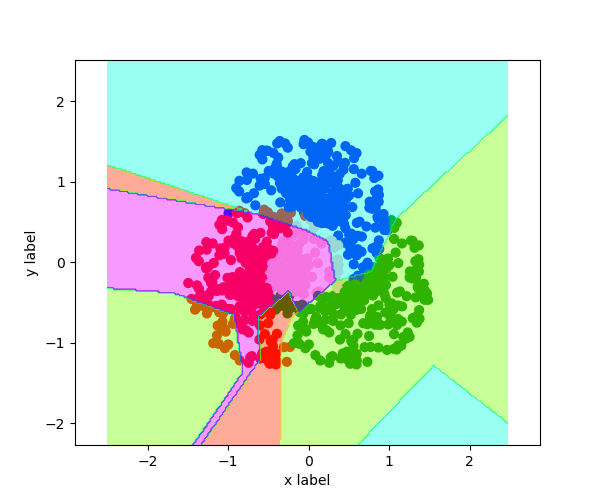

In [68]:
fig, ax = plt.subplots(figsize=(6,5)) 
x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction_without_trick)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

<IPython.core.display.Javascript object>


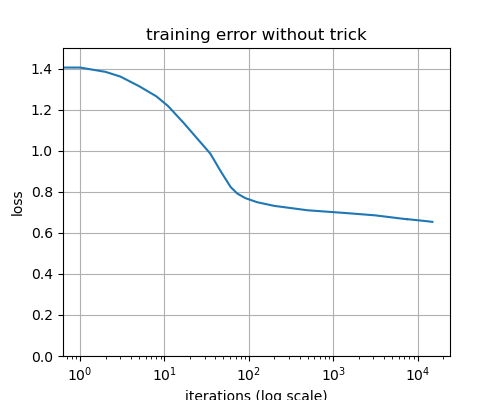

In [69]:
_x = range(len(history_without_trick))
_y = history_without_trick
xlabel = 'iterations (log scale)'
ylabel = 'loss'
title = "training error without trick"
fig, ax = plot(_x, _y, title=title, xlabel=xlabel, ylabel=ylabel,figsize=(5,4))
ax.set_ylim(0.0, 1.5)
ax.set_xscale('log')

## Batch normalization
Observe the effect of the batch normalization by inserting the layer in-between activation and matmul layers.